# Voranalyse und PCA

## Module importieren

In [1]:
### import modules ###
import pandas as pd
import json
import os
import dhs_f
import fnmatch
import pyreadstat
import scipy.stats as stats
import pylab
import matplotlib.pyplot as plt
import fnmatch
import pyreadstat
import re
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plot
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
from statistics import mean
import scipy
import country_converter as coco
import warnings
warnings.filterwarnings('ignore')
import seaborn as sn
from functools import reduce
from sklearn.preprocessing import quantile_transform
from scipy.special import boxcox1p
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from scipy.stats import shapiro

### Sub Samples definieren

In [2]:
female_columns = {"ID": "ID",
"MV012: current age": "V012: current age",
"MV025: Type of Place": "V025: Type of Place",
"MV026: De facto place of residence": "V026: De facto place of residence",
"MV104: years lived in place of residence": "V104: years lived in place of residence",
"MV106: highest educational level": "V106: highest educational level",
"MV133: education in single years": "V133: education in single years",
"MV149: educational attainment": "V149: educational attainment",
"MV155: literacy": "V155: literacy",
"MV156: ever participated in a literacy program (excluding primary school)": "V156: ever participated in a literacy program (excluding primary school)",
"MV157: frequency of reading newspaper or magazine": "V157: frequency of reading newspaper or magazine",
"MV158: frequency of listening to radio": "V158: frequency of listening to radio",
"MV159: frequency of watching television": "V159: frequency of watching television"}

identification = [
'ID',
'HV000: country code',
'HV000.0: country name',
'HV001: cluster number',
'HV007: year of interview',
'HV025: Type of place of residence',
'HV104: sex of household member',
'HV105: age of household members']

child = [
"HV109: educational attainment",
'HV121: member attended school during current school year',
'HV122: educational level during current school year',
'HV123: grade of education during current school year',
'HV124: education in single years - current school year',
'HV125: member attended school during previous school year',
'HV126: educational level during previous school year',
'HV127: grade of education during previous school year',
'HV128: education in single years - previous school year',
'HV129: school attendance status',
'HV122.1: expected primary entrance age',
'HV122.2: expected secondary entrance age',
"HV108: education completed in single years"]

youth = [
'HV108: education completed in single years',
'HV109: educational attainment',
'HV110: Member still in school',
'HV106: highest educational level attained',
"V106: highest educational level",
"V133: education in single years",
"V149: educational attainment",
"V155: literacy",
"V157: frequency of reading newspaper or magazine",
"V158: frequency of listening to radio",
"V159: frequency of watching television"
]

aduld = [
'HV108: education completed in single years',
'HV109: educational attainment',
'HV110: Member still in school',
'HV106: highest educational level attained',
"V155: literacy",
"V157: frequency of reading newspaper or magazine",
"V158: frequency of listening to radio",
"V159: frequency of watching television"]

### Funktionen definieren

In [3]:
def missing_column(dfObj):
    table = pd.DataFrame(dfObj.isna().sum())
    table.reset_index(inplace=True)
    table = table.rename(columns={'index': 'KPI'})
    table[0] = table[0] / len(dfObj.index)
    table = table.rename(columns={0: 'Missing Values Col %'})
    return table.sort_values(by=['Missing Values Col %'], ascending=False)

def missing_column_groupby(dfObj, group):
    new_table = {}
    table = dfObj.drop(group, 1).isna().groupby(dfObj[group], sort=False).sum().reset_index()
    for col in table.columns[1:]:
        cats = {}
        for cat in dfObj[group].unique():
            cats[cat] = table[table[group] == cat][col].sum() / len(dfObj[dfObj[group] == cat].index)
        new_table[col] = cats
    new_table = pd.DataFrame(new_table).reset_index()
    new_table = new_table.rename(columns={'index': f'{group}'})
    return new_table.sort_values(by=[group], ascending=False)

def missing_per_group(dfObj, group, columns):
    columns = columns
    columns.append(group)

    A = dfObj[columns].drop(group, 1).isna().groupby(dfObj[group], sort=False).sum().reset_index()
    B = dfObj[columns].drop(group, 1).fillna(1).groupby(dfObj[group], sort=False).count().reset_index()
    C = pd.DataFrame()

    C[group] = A[group]
    avg_missing = []

    for col in A.columns[1:]:
        C[col] = (A[col] / B[col]).round(2)

    C["Mean"] = C[C.columns[1:]].mean(axis=1).round(2)

    return C.sort_values(by=group)

## Dateien laden und vorbereiten

In [4]:
### set display options ###
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### paths ###
## project ##

#/mnt/datadisk/data/Projects/education/pca/Feature Extraction + PCA.ipynb

projects_p = r"/Users/julii/PycharmProjects/Education/pca"#r"/mnt/datadisk/data/Projects/education/" 
locations_f = projects_p + '/inputs/locations.csv'
codes_to_keep_f = projects_p + '/ressources/codes_and_questions.json'
education_index_unecso = projects_p + "/ressources/EDI.csv"

## codes/questions we want to keep ##
# Opening JSON file
with open(codes_to_keep_f, 'r') as file:
    # returns JSON object as
    # a dictionary
    codes_to_keep = json.load(file)
 
    
#walk folder for finding .tifs
walk_f = r"/mnt/datadisk/"
#Saves loaded Questions/dfs into pickle and reloads because of runtime
load_from_pickle = True
#might be split into urban/rural as well cf. below
out_f = projects_p + '/labels_new.csv'


#load prefiltered data
IR = pd.read_csv(projects_p + f'/ressources/IR.csv')
IR.name = "IR"

PR = pd.read_csv(projects_p + f'/ressources/PR.csv')
PR.name = "PR"

MR = pd.read_csv(projects_p + f'/ressources/MR.csv')
MR.name = "MR"

### Parameter für die Ausgabe anpassen

In [5]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 2000)
pd.set_option('max_colwidth', 1000)

### Intelektuelle Vorauswahl der Attribute
Attribute, die relevant sind, wurden bereits mit "extract_data.py" extrahiert. Eingeschlossen wurden Variablen, die demographische und geografische Daten enthalten, sowie Variablen die Aufschluss über die Bildungssituation geben.
Folgende Daten wurden extrahiert:

PR: Personal Recode (Individuellen Einträge der Haushaltsmitglieder)
- Bisher Erreichte Bildung (Jahre, Level, Grad, Besuchsstatus)
- Kinder, junge Erwachsene zwischen 5 und 24 Jahren:
    - Bildungssituation in diesem und im vorherigen Schuljahr (Jahre, Level, Grad, Besuchsstatus, Anwesenheit)
    
IR: Individual Recode (Frauen im gebährfähigen Alter [15-49])
- PR*
- zusätlich Fragen zur Alphabetisierung 
    
MR: Men Recode (äquivalent zu IR; Männer im gleichen Alter [15-49])
- PR*
- zusätlich Fragen zur Alphabetisierung  

Die Fragebögen wurden über eine ID (Land+Version, Cluster, CASEID) miteinader verknüpft, wobei sich einige Variablen doppeln.

In [6]:
for df in [IR, MR, PR]:
    
    #drop Unnamed columns
    try:
        df.drop("Unnamed: 0", axis=1, inplace = True)
    except:
        pass
    
    # Primary key erstellen (ID) anhand derer, die Fragebogen verknüpft werden    
    if df.name == "IR":
        df['CASEID'] = df["V001"].apply(lambda x: str(x).split(".")[0]) + "." + df["V002"].apply(lambda x: str(x).split(".")[0]) + "." + df["V003"].apply(lambda x: str(x).split(".")[0])
        df.insert(0, 'ID', df["CASEID"] + "." + df["V000"] + "." + df["V007"].apply(lambda x: str(x).split(".")[0]))
        df.drop(columns=["CASEID", "V001", "V002", "V000", "V007"], inplace=True) 
    if df.name == "PR":    
        df.insert(0, 'CASEID', df["HV001"].apply(lambda x: str(x).split(".")[0]) + "." + df["HV002"].apply(lambda x: str(x).split(".")[0]) + "." + df["HVIDX"].apply(lambda x: str(x).split(".")[0]))
        df.insert(0, 'ID', df["CASEID"] + "." + df["HV000"] + "." + df["HV007"].apply(lambda x: str(x).split(".")[0]))
        df.drop(columns=["CASEID"], inplace=True) 
    if df.name == "MR":
        df.insert(0, 'CASEID', df["MV001"].apply(lambda x: str(x).split(".")[0]) + "." + df["MV002"].apply(lambda x: str(x).split(".")[0]) + "." + df["MV003"].apply(lambda x: str(x).split(".")[0]))
        df.insert(0, 'ID', df["CASEID"] + "." + df["MV000"] + "." + df["MV007"].apply(lambda x: str(x).split(".")[0]))
        df.drop(columns=["CASEID", "MV001", "MV002", "MV000", "MV007"], inplace=True)  
    
    df["ID"] = df["ID"].astype(str)
    df.dropna(subset=["ID"], inplace=True)
    
    # Nur die relevanten Spalten behalten
    for col in df.columns:
        if col not in codes_to_keep[df.name].keys():
            if col not in ["GEID", "ID"]:
                df.drop(columns=[col], inplace = True)
        else:
            df.rename(columns={col: f"{col}: {codes_to_keep[df.name][col]}"}, inplace=True)

### Daten zusammenführen und ergänzen: 
#### Eintrittsalter der Primär- und Sekundärtstufe auf Landesebene
Es werden zusätzlichen Daten werden benötigt, um die Einschreibungsraten der verschiedenen Schulstufen auf Landesebene zu bestimmen. Das Eintrittsalter der Primär, Sekundär oder tertiärstuffe weißt landesspezifische Unterschiede auf. ISCED* Versucht diese zu standartisieren, im DHS Fragebogen wird der Bildungsstand einem standartisierte Level zugeordnet. Eine zuverlässige Zuordnung ist aufgrund der mangelnden datenlage noch nicht möglich. Das Eintrittsalter wird von der UNESCO anhand historischer Durschschnittswerte bestimmt. 

In [7]:
#### Datensätze Zusammenführen
for key, val in female_columns.items():
    MR.rename(columns={key: val}, inplace=True)
            
INDIVIDUALS = pd.concat([IR, MR])[female_columns.values()]
DHS = PR.merge(INDIVIDUALS, on="ID", how='outer', sort=True)

#### Add country code
DHS['HV000: country code'] = DHS['HV000: country code and phase'].replace(to_replace=r'[0-9]+', value="", regex=True) 
DHS['HV025: Type of place of residence'] = DHS['HV025: Type of place of residence'].replace([1,2], ["urban", "rural"]) 
DHS["HV104: sex of household member"] = DHS["HV104: sex of household member"].replace([1,2], ["male", "female"])

#### Eintrittsalter der Primärstufe
dir_path = projects_p + '/ressources/primary_entrance.csv'
df1 = pd.read_csv(dir_path, sep=";")
df1 = df1.melt(id_vars=['Country Name', 'Country Code'], var_name='HV007: year of interview', value_name='Primary Entrance Age')

#### Eintrittsalter der Tertiarstufe
dir_path = projects_p + '/ressources/secondary_entrance.csv'
df2 = pd.read_csv(dir_path, sep=";")
df2 = df2.melt(id_vars=['Country Name', 'Country Code'], var_name='HV007: year of interview', value_name='Secondary Entrance Age')

#### Datensätze Zusammenführen
df = df1.merge(df2, on=['Country Name', 'Country Code', 'HV007: year of interview'], how="outer")
df['HV007: year of interview'] = df['HV007: year of interview'].astype(int)
df.rename(columns={"Country Name": "HV000.0: country name",
                  "Primary Entrance Age": "HV122.1: expected primary entrance age",
                  "Secondary Entrance Age": "HV122.2: expected secondary entrance age"
                  }, inplace=True)

#### ISO2-Codes ergänzen
cc = coco.CountryConverter()
df["HV000: country code"] = df["HV000.0: country name"].apply(lambda x: cc.convert(names=x, to='ISO2'))
df.drop(columns="Country Code", inplace=True)

#### ISO2-Codes mit den Umfragdaten Zusammenführen
DHS = DHS.merge(df, on=['HV000: country code', 'HV007: year of interview'], how="left")
DHS = DHS[DHS["HV001: cluster number"].isna()==False]
DHS.insert(0, 'DHSID', DHS["HV000: country code"]+DHS["HV007: year of interview"].apply(lambda x: str(x)[:4])+DHS["HV001: cluster number"].apply(lambda x: str(int(x)).rjust(8, "0")))   

Africa Eastern and Southern not found in regex
Africa Western and Central not found in regex
Arab World not found in regex
Central Europe and the Baltics not found in regex
Channel Islands not found in regex
Caribbean small states not found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
High income not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in regex
IDA only not found in regex
Not classified not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean not found in regex
Least developed countries: UN classification not fo

Latin America & the Caribbean (IDA & IBRD countries) not found in regex
Middle East & North Africa (IDA & IBRD countries) not found in regex
South Asia (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD countries) not found in regex
Turkiye not found in regex
Upper middle income not found in regex
World not found in regex
Africa Eastern and Southern not found in regex
Africa Western and Central not found in regex
Arab World not found in regex
Central Europe and the Baltics not found in regex
Channel Islands not found in regex
Caribbean small states not found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
High income not found in regex
Heavily indebted poor countries (HIPC) not found i

Post-demographic dividend not found in regex
South Asia not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa not found in regex
Small states not found in regex
East Asia & Pacific (IDA & IBRD countries) not found in regex
Europe & Central Asia (IDA & IBRD countries) not found in regex
Latin America & the Caribbean (IDA & IBRD countries) not found in regex
Middle East & North Africa (IDA & IBRD countries) not found in regex
South Asia (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD countries) not found in regex
Turkiye not found in regex
Upper middle income not found in regex
World not found in regex
Africa Eastern and Southern not found in regex
Africa Western and Central not found in regex
Arab World not found in regex
Central Europe and the Baltics not found in regex
Channel Islands not found in regex
Caribbean small states not found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Paci

Middle East & North Africa not found in regex
Middle income not found in regex
Middle East & North Africa ( not found in regex
North America not found in regex
OECD members not found in regex
Other small states not found in regex
Pre-demographic dividend not found in regex
Pacific island small states not found in regex
Post-demographic dividend not found in regex
South Asia not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa not found in regex
Small states not found in regex
East Asia & Pacific (IDA & IBRD countries) not found in regex
Europe & Central Asia (IDA & IBRD countries) not found in regex
Latin America & the Caribbean (IDA & IBRD countries) not found in regex
Middle East & North Africa (IDA & IBRD countries) not found in regex
South Asia (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD countries) not found in regex
Turkiye not found in regex
Upper middle income not found in regex
World not found in regex
Africa Eastern and Southern not 

### Übergeordnete Datenqualität beurteilen
______________________________________________________________________________________________________________________________
https://de.surveymonkey.com/curiosity/bereinigung-von-umfragedaten-7-punkte-die-sie-vor-beginn-ihrer-analyse-pruefen-sollten/

- **Duplikate**: Datenreihen werden dedupliziert. 
- **Übertragungsfehler/Messfehler**: Enthalten Datenreihen Werte für die Schulbesuchsdauer, die unrealistisch sind. Subtrahiert man das minimalen Einstiegsalter der Primärtstufe (5 Jahre) vom eigentlichen Alter der Person, sollte die Schulbesuchsdauer diese Wert nicht überschreiten. Einträge, die diesem Kriterium wiedersprechen, sollten entfernt werden, da es sich sehr wahrscheinlich um einen Erfassungsfehler handelt, sehr deutlich ist dies, wenn eine 14 jährige bereits 17 jahre zu Schule gegangen sein soll.
- **Missing Values (MCAR, MAR and MNAR)**: Der relative Anteil der fehlenden Werte ist ein weiteres kritisches Kriterium dafür, ob eine Variable beibehalten werden soll. Wenn gegebenfalls nur XX% der Daten fehlen, sollten Imputations-Strategien angewandt werden, um fehlende Daten zu ergänzen. Wird für die Sample bzw. die Variablen seperat betrachtet. Es gibt jedoch verschiedene Ursachen und Datentypen, für die sich jeweils andere Strategien eignen.
- **Sample-Größe**: Anzahl der Studienteilnehmer eines Clusters, in Abhängigkeit der Altersgruppen.
_______________________________________________________________________________________________________________________________
https://docs.rapidminer.com/10.0/studio/operators/cleansing/quality_measures.html

#### Relevante Erhebungsjahre

In [8]:
DHS = DHS[(DHS["HV007: year of interview"]>2009)]

<Axes: >

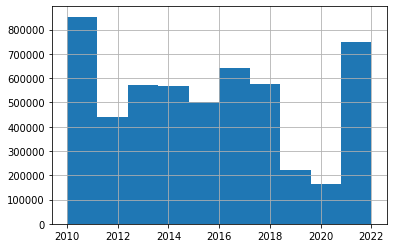

In [9]:
DHS["HV007: year of interview"].hist()

#### Duplikate entfernen

Um mögliche Verzerrungen durch Dopplungen auzuschließen, wird überprüft, ob duplizierte Datenreihen vorhanden sind. Dies wird anhand der ID überprüft, da diese genau für einen befragten steht..

In [10]:
# Duplikate entfernen
DHS.sort_values(by="HV007: year of interview").drop_duplicates(subset="ID", inplace=True, keep="first")

#### "Keine Ahnung" 8, bzw. 98
Wenn ein befragter die Antwort nicht kennt, wird der entsprechende Wert, 8 oder 98 eingetragen.Die Kategorie "Keine Ahnung" hat in diesem Zusammenhang einen sehr geringen Informationsgehalt (insbesondere in Anbetracht der PCA und sollte als "Missing" behandelt werden.

In [11]:
for col in child + youth + aduld:
    if DHS[col].max()==8:
        DHS[col].replace(8, np.nan, inplace=True)
    if DHS[col].max()==98:
        DHS[col].replace(98, np.nan, inplace=True)     

#### Übertragungsfehler/Messfehler: Inkosistenten Altersangaben

Es gibt Einträge, bei denen die Anzahl der aktuellen bzw. abgeschlossesenen Schuljahre über den Lebensjahren der Person liegt.
Bei diesen Einträgen handelt es sich mutmaßlich um Übertragunsfehler, technische Fehler beim scannen der Umfragen.
Die betroffenen Einträge werden entfernt. Ein weiterer Indikator für Übertragunsfehler ist, wenn jemand mindestens in der 2. Stuffe ist, jedoch 0 Schuljahre abgeschlossen hat. Nicht alle möglichen Falscheinträge sind so offensichtlich, die aufgeführten Fällen, sind jedoch eine offensichtliche Ursache für Rauschen und sollten entfernt werden. Ob die Einträge Wahrheitsgemess und korrekt eingetragen wurden, obliegt dem Vertrauen.

In [12]:
INCONSISTENT = DHS[((DHS["HV128: education in single years - previous school year"] > 18)) |((DHS["HV105: age of household members"] < DHS["HV128: education in single years - previous school year"])) | ((DHS["HV105: age of household members"] < DHS["HV108: education completed in single years"]) | (DHS["HV105: age of household members"] +5 < DHS["HV124: education in single years - current school year"])) | ((DHS['HV109: educational attainment'] >= 2) & (DHS["HV108: education completed in single years"]==0) | (DHS["HV108: education completed in single years"]>18) | (DHS["HV124: education in single years - current school year"] > 18))]
DHS = DHS.drop(INCONSISTENT.index)   

#### Nicht-Bewohner exkludieren
Bewohner werden befragt, ob Sie in dem jeweiligen Haushalt wohnhaft sind, oder ob sie lediglich zu Gast sind. Die jenigen, die zu Gast sind, oder keine sichere Angabe machen, werden exkludiert, da diese möglicherweise anderen Clustern zugehörig sind.

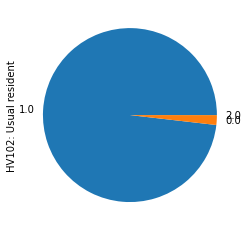

In [13]:
try:
    DHS['HV102: Usual resident'].fillna(2).value_counts().plot.pie(figsize=(4,4))
except:
    pass
DHS = DHS[DHS["HV102: Usual resident"]==1]

#### Nur eindeutig weibliche und männliche Teilnehmer berücksichtigen

<Axes: ylabel='HV104: sex of household member'>

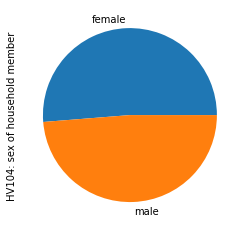

In [14]:
DHS = DHS[DHS["HV104: sex of household member"].isin(["male", "female"])==True]
DHS['HV104: sex of household member'].fillna(2).value_counts().plot.pie(figsize=(4,4))

#### Nur eindeutig städtisch oder ländlich lebende Teilnehmer berücksichtigen

<Axes: ylabel='HV025: Type of place of residence'>

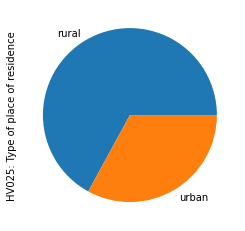

In [15]:
DHS = DHS[DHS['HV025: Type of place of residence'].isin(["urban", "rural"])==True]
DHS['HV025: Type of place of residence'].fillna(2).value_counts().plot.pie(figsize=(4,4))

<Axes: title={'center': 'HV108: education completed in single years'}, xlabel='HV025: Type of place of residence'>

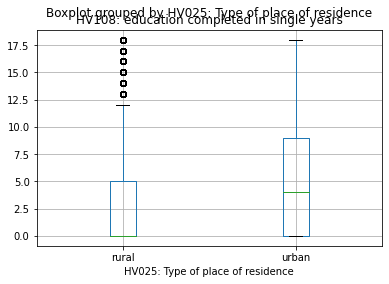

In [16]:
DHS.boxplot(column="HV108: education completed in single years", by='HV025: Type of place of residence')

In [17]:
DHS["HV105: age of household members"].describe().round(3)

count    5177625.000
mean          22.414
std           19.399
min            0.000
25%            7.000
50%           16.000
75%           34.000
max           98.000
Name: HV105: age of household members, dtype: float64

### Altersstruktur

Text(0, 0.5, 'Alter')

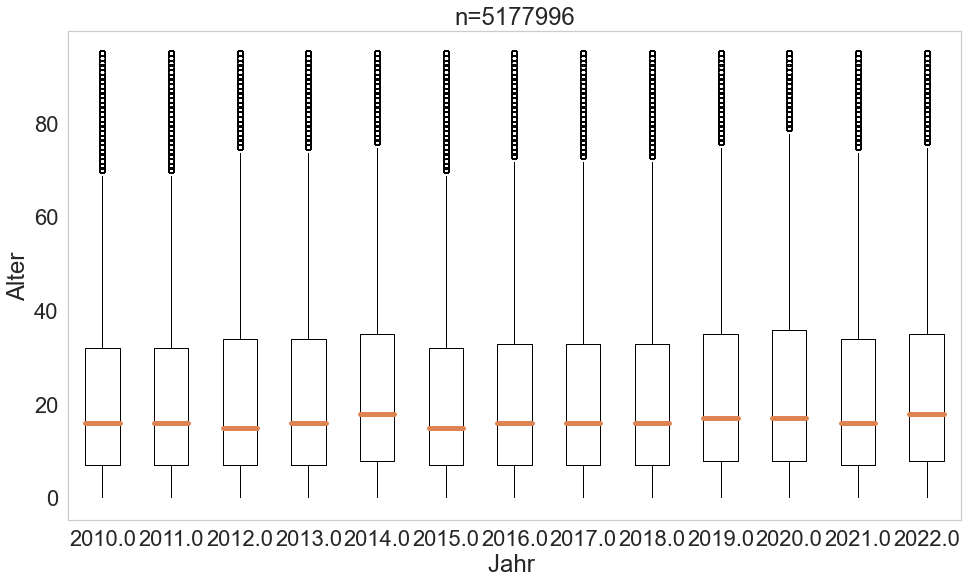

In [18]:
n = len(DHS.index)
import seaborn as sns

sns.set(font_scale=2)
sns.set_style("whitegrid", {'axes.grid' : False})

age_plot = DHS[["HV105: age of household members", 'HV007: year of interview']].replace([96,97,98], np.nan)
age_plot.plot(kind='box', color={'medians': 'grey', 'caps': "white"}, figsize=(16,9), grid=False, 
        medianprops={'linewidth': 5}, by='HV007: year of interview', colormap="cubehelix")
plt.title(f"n={n}")
plt.xlabel('Jahr ')
plt.ylabel('Alter')

In [19]:
DHS["HV105: age of household members"].describe().round(3)

count    5177625.000
mean          22.414
std           19.399
min            0.000
25%            7.000
50%           16.000
75%           34.000
max           98.000
Name: HV105: age of household members, dtype: float64

In [20]:
DHS[["HV105: age of household members", 'HV007: year of interview']].groupby('HV007: year of interview').quantile(0.25)

HV105: age of household members
HV007: year of interview                                 
2010.0                                                7.0
2011.0                                                7.0
2012.0                                                7.0
2013.0                                                7.0
2014.0                                                8.0
2015.0                                                7.0
2016.0                                                7.0
2017.0                                                7.0
2018.0                                                7.0
2019.0                                                8.0
2020.0                                                8.0
2021.0                                                7.0
2022.0                                                8.0

In [21]:
DHS[["HV105: age of household members", 'HV007: year of interview']].groupby('HV007: year of interview').median().min()

HV105: age of household members    15.0
dtype: float64

## Samples
In Abhängigkeit des Alters werden den befragten andere Fragen zur Bildung gestellt. Die erste Gruppe wird mit 60% gewichtet, die zweite mit 40%. Dies entspricht in etwa der ltersstruktur im  gesamten Datensatz.

#### Gruppe 1: Kinder, Jugendliche, heranwachsende und junge Erwachsene zwischen 6 und 24 Jahren
- In dieser Altersgruppe wird erwartet, dass die befragten die Primär-, Sekundär- oder eine höhere Bildugnsstufe besuchen.

- Berechnet werden für diese Altersstufe folgende Werte:
    - 1) Die Erwartete Schulbesuchsdauer (6-24 Jahre)
    - 2) Besuchsquote einer Schulstufe. Das erwarte Eintrittsalter einer Schulstufe, wird vom jeweiligen Land vorgegeben.
        - 1. Besuchsquote der Primärstufe
            - 1. Brutto *Gross enrollment ratio
            - 2. Netto *Total net enrollment rate
        - 2. Besuchsquote der Sekundärstufe
            - 1. Brutto
            - 2. Netto 
    - 3) Jugend Alphabetisierungrate
    - 4) Jugend Abschlussrate
        - 1. Primärstufe
        - 2. Sekundärtstufe
    - ... Eines Jahres, auf Clusterebene und nach Region (Urban, Ländlich)    
        
*Percentage of a cohort of children or young people aged 3-5 years above the intended age for the last grade of each level of education who have completed that grade.

________________________________________________________________________________________________________________________________
https://uis.unesco.org/en/glossary-term/youthadult-educational-attainment-rates-age-group-and-level-education
https://data.worldbank.org/indicator/SE.PRM.ENRR?locations=ZG

#### Gruppe 2: Erwachsene, zwischen 25 und 49. 
- In dieser Altersgruppe wird erwartet, dass die befragten nicht mehr im Schulsystem integriert sind / ihre Schulbildung bereits abgeschlossen haben.

- Teilnehmer zwischen 15 und 49 werden zur Gruppe der gebährfähigen gezählt. In vorherigen Studien wurde festgestellt, dass die elterliche Bildung, inbesondere die der Mutter, positiv mit der Bildung und der Gesundheit der Nachkommen zusammen wirkt. In dieser Alterklasse befinden sich zudem Lehrkräfte.
- Berechnet werden folgende Werte:
    - 1) Durchschnittliche Anzahl erreichter Schuljahren
    - 2) Erwachsenen-Bildungsquoten nach Bildungsniveau
        - 1. Abschlussrate der Primärstufe
        - 2. Abschlussrate der Sekundärstufe
    - 3) Erwachsenen Alphabetisierungrate*
    - ... Eines Jahres, auf Clusterebene und nach Region (Urban, Ländlich)   

*Der Indikator misst für jedes Bildungsniveau den Prozentsatz der Bevölkerung, der mindestens dieses Bildungsniveau abgeschlossen hat. Die Bildungsniveaus sind nach der Internationalen Standardklassifikation für das Bildungswesen (ISCED) definiert.
    
Zusätzlich wird zu jedem Wert der jeweilige GPI berechnet. Der Gender Parity Index (GPI) zeigt die Parität zwischen Mädchen und Jungen an. Ein GPI von weniger als 1 deutet darauf hin, dass Mädchen bei den Lernmöglichkeiten stärker benachteiligt sind als Jungen, und ein GPI von mehr als 1 bedeutet, dass es umgekehrt ist.
*https://databank.worldbank.org/metadataglossary/millennium-development-goals/series/SE.ENR.PRSC.FM.ZS#:~:text=The%20Gender%20Parity%20Index%20(GPI,suggests%20the%20other%20way%20around.

### Gruppe 1: Kinder, Jugendliche, heranwachsende und junge Erwachsene (m, f, d) zwischen 6 und 24 Jahren.

In [22]:
SAMPLE_PUPILS = DHS[(DHS["HV105: age of household members"]<25)&(DHS["HV105: age of household members"]>=6)][identification + list(set(child))].copy()

In [23]:
indikators = [pd.DataFrame(SAMPLE_PUPILS[child].mean()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MEAN"}),
    pd.DataFrame(SAMPLE_PUPILS[child].median()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MEDIAN"}),
    pd.DataFrame(SAMPLE_PUPILS[child].min()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MIN"}),
    pd.DataFrame(SAMPLE_PUPILS[child].max()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MAX"}),    
    pd.DataFrame(SAMPLE_PUPILS[child].std()).reset_index().rename(columns={"index": "INDIKATOR", 0: "STD"}),
    pd.DataFrame(SAMPLE_PUPILS[child].var()).reset_index().rename(columns={"index": "INDIKATOR", 0: "VAR"}),
    pd.DataFrame(SAMPLE_PUPILS[child].isna().sum()/len(SAMPLE_PUPILS.index)).reset_index().rename(columns={"index": "INDIKATOR", 0: "MISSING%"})]

indikators = reduce(lambda left, right: pd.merge(left, right, on="INDIKATOR", how='outer'), indikators)  
indikators = indikators.sort_values(by="MISSING%").round(2)
indikators

INDIKATOR   MEAN  MEDIAN   MIN   MAX   STD    VAR  MISSING%
10                     HV122.1: expected primary entrance age   6.26     6.0   6.0   7.0  0.44   0.19      0.05
11                   HV122.2: expected secondary entrance age  12.34    12.0  11.0  14.0  0.73   0.54      0.05
0                               HV109: educational attainment   1.34     1.0   0.0   5.0  1.18   1.40      0.18
12                 HV108: education completed in single years   3.89     3.0   0.0  18.0  3.78  14.32      0.18
1    HV121: member attended school during current school year   1.24     2.0   0.0   2.0  0.96   0.93      0.20
2         HV122: educational level during current school year   0.78     1.0   0.0   3.0  0.74   0.55      0.20
4      HV124: education in single years - current school year   3.12     2.0   0.0  18.0  3.65  13.34      0.21
3        HV123: grade of education during current school year   3.34     3.0   0.0  12.0  1.88   3.54      0.52
5   HV125: member attended school during previous school year   0.61     1.0   0.0   1.0  0.49   0.24      0.78
6        HV126: educational level during previous school year   0.72     1.0   0.0   3.0  0.72   0.52      0.78
8     HV128: education in single years - previous school year   2.84     1.0   0.0  18.0  3.47  12.07      0.78
9                             HV129: school attendance status   2.01     2.0   0.0   5.0  1.53   2.33      0.79
7       HV127: grade of education during previous school year   3.29     3.0   0.0   8.0  1.95   3.81      0.87

In [24]:
#indikators.to_csv(r"C:\Users\julii\Downloads\child_table.csv")

Variablen die sich auf das vorherige Schuljahr beziehen, liefern zwar Informationen über Schulabbrecher, Wiederholer, Rückkehrer und Übergänger, allerdings werden im Verhältnis zur Grundgesamtheit nicht ausreichend Schüler befragt.
*Die Fragenbögen enthalten zwar einen Anteil standartisierter Fragen, fragen zum vorherigen Schuljahr gehören nicht dazu.

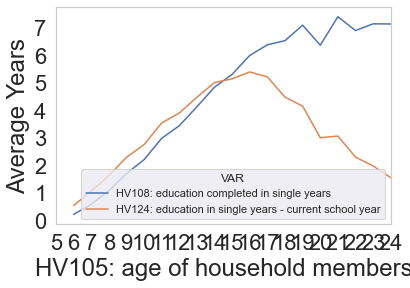

In [25]:
import seaborn as sns

SAMPLE_PUPILS_TS = pd.DataFrame(SAMPLE_PUPILS.set_index("HV105: age of household members")[["HV108: education completed in single years", "HV124: education in single years - current school year"]]).groupby("HV105: age of household members").mean()
SAMPLE_PUPILS_TS = SAMPLE_PUPILS_TS.stack().reset_index().rename(columns={"level_1": "VAR", 0: "Average Years"})

# plot distplot
fig, ax = plt.subplots()

sns.set(font_scale=2)
sns.set(rc={'figure.figsize':(16,9)})
sns.lineplot(y = "Average Years", x = "HV105: age of household members", hue="VAR", data = SAMPLE_PUPILS_TS, ax = ax)

# change the limits of X-axis
ax.set_xlim(5, 24)
ax.set_xticks([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]) 
plt.show()

#### 1) Die Erwartete Schulbesuchsdauer (6-24 Jahre)
*https://globaldatalab.org/shdi/metadata/esch/

Vorraussetzung für die Berechnung ist, dass 'HV121: member attended school during current school year' nicht fehlt. Die jenigen, für die mindestens 2 ("Attended at some time") erfüllt ist, werden als Schulbesucher gezählt. Zudem, muss zu jedem Alter zwischen 6 und 25 mindestens eine Beobachtungen existieren. Die Schulbesuchsquote jedes Alter wird berechnet und summiert. Bei circa 50% der Cluster fehlen allerdings Beobachtungen für bestimmte Altersstufen. Wenige fehlende Einträge, können mit dem Mittelwert aus dem höheren und niedrigerem Alter imputiert werden. 

In [26]:
### Imputation

from collections import defaultdict

def f(x):
    d = {}
    for y, z in zip(*x):
        d[y]=z
    return d


def impute(x):
    imputed = {}
    
    for age in range(6,25,1):
        if x.get(age) is not None:
            imputed[age] = x[age]
        elif age == 6:
            imputed[age] = 0.0
        elif age == 24:
            imputed[age] = 0.0
        elif x.get(age+1) is not None and x.get(age-1) is not None:
                imputed[age] = ((x[age+1] + x[age-1])/2)
        elif x.get(age+1) is not None and x.get(age-2) is not None:
                imputed[age] = ((x[age+1] + x[age-2])/2)        
        elif x.get(age+2) is not None and x.get(age-1) is not None:
                imputed[age] = ((x[age+2] + x[age-1])/2)    
        elif x.get(age+2) is not None and x.get(age-2) is not None:
                imputed[age] = ((x[age+2] + x[age-2])/2) 
        elif x.get(age+1) is not None and x.get(age-1) is None:
                imputed[age] = ((x[age+1] + 0)/2) 
        elif x.get(age+1) is None and x.get(age-1) is not None:
                imputed[age] = ((0 + x[age-1])/2)        
        elif x.get(age+2) is not None and x.get(age-2) is None:
                imputed[age] = ((x[age+2] + 0)/2) 
        elif x.get(age+2) is None and x.get(age-2) is not None:
                imputed[age] = ((0 + x[age-2])/2)
    return imputed

In [27]:
def ExpectedYearsOfSchooling(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]

    ### Remove cluster that didn't ask this questions
    EYS = SAMPLE_PUPILS
    EYS = EYS.dropna(subset='HV121: member attended school during current school year')

    ### Replace unnecessary attendance states by None and replace the relevant one with 1
    EYS['HV121: member attended school during current school year'] = EYS['HV121: member attended school during current school year'].replace([0,4], np.NaN).replace(2,1)

    ### Define the attendance rate for the existing age levels
    EYS = EYS[['HV121: member attended school during current school year', "ID", "HV105: age of household members"] + cols].groupby(cols+["HV105: age of household members"]).count().reset_index()
    EYS["ATTENDANCE_RATE_PER_AGE"] = EYS["HV121: member attended school during current school year"]/EYS["ID"]

    ### Group dictionaries
    EYS = EYS[cols + ["ATTENDANCE_RATE_PER_AGE", "HV105: age of household members"]].groupby(cols).agg(list).reset_index()
    EYS['AGE: ATTENDANCE_RATE'] = [ f(x) for x in EYS[['HV105: age of household members', 'ATTENDANCE_RATE_PER_AGE']].to_numpy()]

    ### Impute and keep entries that have values on all age levels and repeat
    EYS['AGE: ATTENDANCE_RATE - IMPUTED'] = EYS['AGE: ATTENDANCE_RATE'].apply(lambda x: impute(x)).apply(lambda x: impute(x))    
    EYS['AGE: ATTENDANCE_RATE- LENGTH'] = EYS['AGE: ATTENDANCE_RATE - IMPUTED'].apply(len)
    EYS = EYS[EYS['AGE: ATTENDANCE_RATE- LENGTH']==19] 

    ###  and sum up the eys
    EYS['ExpectedYearsOfSchooling'] = EYS['AGE: ATTENDANCE_RATE - IMPUTED'].apply(lambda x: sum(x.values())).apply(lambda x: 18.0 if x > 18.0 else x)
    EYS = EYS[cols + ['ExpectedYearsOfSchooling']].sort_values(by='ExpectedYearsOfSchooling')
    
    return EYS.dropna()

EYS = ExpectedYearsOfSchooling('HV104: sex of household member')
EYS = EYS.pivot(index=["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="ExpectedYearsOfSchooling").reset_index().rename(columns={
                 "female": "ExpectedYearsOfSchooling_female",
                 "male": "ExpectedYearsOfSchooling_male"})

EYS["ExpectedYearsOfSchooling_GPI"] = EYS["ExpectedYearsOfSchooling_female"]/EYS["ExpectedYearsOfSchooling_male"]
EYS["ExpectedYearsOfSchooling_GPI"].replace(np.inf, np.NaN, inplace=True)
EYS["ExpectedYearsOfSchooling_GPI"] = EYS["ExpectedYearsOfSchooling_GPI"].apply(lambda x: 18.0 if x > 18.0 else x)

#### 2) Besuchsquote einer Schulstufe
##### 2.1) Die Anwesenheitsquote der Primärstufe. 
###### 2.1.1) Brutto *Gross enrollment ratio 
*https://globaldatalab.org/shdi/metadata/esch/    
*https://uis.unesco.org/en/glossary

In [28]:
# Zuweisung der landesspezifischen Sculstuffe (*ISCED)

def prescribed_level(row):
    try:       
        if (row["HV105: age of household members"] >= row['HV122.2: expected secondary entrance age']) & (row["HV105: age of household members"] < 18.0):        
            return 2.0
        if (row["HV105: age of household members"] < row['HV122.2: expected secondary entrance age']) & (row["HV105: age of household members"] >= row['HV122.1: expected primary entrance age']):
            return 1.0
        if (row["HV105: age of household members"] < row['HV122.1: expected primary entrance age']):
            return 0.0  
        if (row["HV105: age of household members"] >= 18.0):
            return 3.0
    except:
        return 99.0

SAMPLE_PUPILS['HV122.1: educational level prescribed during current school year'] = SAMPLE_PUPILS.apply(prescribed_level, axis=1)

In [29]:
def GrossPrimaryEnrollmentRate(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]
    
    ### Keep only candidates that have been asked and those that enrolled or had to be enrolled in the primary level
    df = SAMPLE_PUPILS
    
    df = df.dropna(subset=["HV122: educational level during current school year", 'HV121: member attended school during current school year', 'HV122.1: educational level prescribed during current school year'])   
    df = df[df["HV122: educational level during current school year"]!=8]
    
    df.loc[(df["HV121: member attended school during current school year"].isna()==True) & 
                  (df["HV122: educational level during current school year"].isna()==True)]
    
    df['HV122.1: educational level prescribed during current school year'] = df['HV122.1: educational level prescribed during current school year'].replace([0,2,3], np.NaN)
    df["HV122: educational level during current school year"] = df["HV122: educational level during current school year"].replace([0,2,3,8], np.nan)
    
    ### Calculate enrollment rate
    df = df.groupby(cols).count().reset_index()
    
    df["GrossPrimaryEnrollmentRate"] = df["HV122: educational level during current school year"]/df['HV122.1: educational level prescribed during current school year']
    df = df[cols + ["GrossPrimaryEnrollmentRate"]].sort_values(by="GrossPrimaryEnrollmentRate")   
    df["GrossPrimaryEnrollmentRate"] = df["GrossPrimaryEnrollmentRate"].replace(np.inf, np.NaN)   
    df["GrossPrimaryEnrollmentRate"] = df["GrossPrimaryEnrollmentRate"].astype(float)
    df = df.dropna(subset="GrossPrimaryEnrollmentRate")

    return df.dropna()

GPER = GrossPrimaryEnrollmentRate('HV104: sex of household member')
GPER = GPER.pivot(index=["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="GrossPrimaryEnrollmentRate").reset_index().rename(columns={
                 "female": "GrossPrimaryEnrollmentRate_female",
                 "male": "GrossPrimaryEnrollmentRate_male"})

GPER["GrossPrimaryEnrollmentRate_GPI"] = GPER["GrossPrimaryEnrollmentRate_female"]/GPER["GrossPrimaryEnrollmentRate_male"]
GPER["GrossPrimaryEnrollmentRate_GPI"].replace(np.inf, np.NaN, inplace=True)

#### 2) Besuchsquote einer Schulstufe
##### 2.1) Die Anwesenheitsquote der Primärstufe. 
###### 2.1.2) Netto *Net attendance ratio

In [30]:
def NetPrimaryEnrollmentRate(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]
    
    ### Keep only candidates that have been asked
    df = SAMPLE_PUPILS
    df = df.dropna(subset=["HV122: educational level during current school year", 'HV121: member attended school during current school year', 'HV122.1: educational level prescribed during current school year'])   
    df = df[df["HV122: educational level during current school year"]!=8]
    
    ### Keep those that enrolled or had to be enrolled in the primary level
    df = df[df['HV122.1: educational level prescribed during current school year']==1]
    df["HV121: member attended school during current school year"] = df["HV121: member attended school during current school year"].replace([0,8], np.nan)
    df["HV122: educational level during current school year"] = df["HV122: educational level during current school year"].replace([0,2,3], np.nan)    
    df = df[cols + ["HV122: educational level during current school year",'HV122.1: educational level prescribed during current school year']]

    ### Calculate enrollment rate
    df = df[[ 'HV122: educational level during current school year', 'HV122.1: educational level prescribed during current school year'] + cols].groupby(cols).count().reset_index()
    df["NetPrimaryEnrollmentRate"] = df["HV122: educational level during current school year"]/df["HV122.1: educational level prescribed during current school year"]    
    df["NetPrimaryEnrollmentRate"] = df["NetPrimaryEnrollmentRate"].astype(str).astype('float').replace(np.inf, np.NaN)
    df = df[cols + ['NetPrimaryEnrollmentRate']].dropna(subset="NetPrimaryEnrollmentRate")

    return df.dropna()

NPER = NetPrimaryEnrollmentRate('HV104: sex of household member')
NPER = NPER.pivot(index=["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="NetPrimaryEnrollmentRate").reset_index().rename(columns={
                 "female": "NetPrimaryEnrollmentRate_female",
                 "male": "NetPrimaryEnrollmentRate_male"})

NPER["NetPrimaryEnrollmentRate_GPI"] = NPER["NetPrimaryEnrollmentRate_female"]/NPER["NetPrimaryEnrollmentRate_male"]
NPER["NetPrimaryEnrollmentRate_GPI"].replace(np.inf, np.NaN, inplace=True)

#### 2) Besuchsquote einer Schulstufe
##### 2.2) Die Anwesenheitsquote der Sekundärstufe. 
###### 2.2.1) Brutto *Gross enrollment ratio

In [31]:
SAMPLE_PUPILS["HV122: educational level during current school year"].value_counts()

1.0    789160
0.0    718997
2.0    276815
3.0     20640
Name: HV122: educational level during current school year, dtype: int64

In [32]:
def GrossSecondaryEnrollmentRate(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]
    
    ### Keep only candidates that have been asked and those that enrolled or had to be enrolled in the primary level
    df = SAMPLE_PUPILS
    
    df = df.dropna(subset=["HV122: educational level during current school year", 'HV121: member attended school during current school year', 'HV122.1: educational level prescribed during current school year'])   
    df = df[df["HV122: educational level during current school year"]!=8]
    
    df.loc[(df["HV121: member attended school during current school year"].isna()==True) & 
                  (df["HV122: educational level during current school year"].isna()==True)]
    
    df['HV122.1: educational level prescribed during current school year'] = df['HV122.1: educational level prescribed during current school year'].replace([0,1,3], np.NaN)
    df["HV122: educational level during current school year"] = df["HV122: educational level during current school year"].replace([0,1,3,8], np.nan)
    
    ### Calculate enrollment rate
    df = df.groupby(cols).count().reset_index()
    df["GrossSecondaryEnrollmentRate"] = df["HV122: educational level during current school year"]/df['HV122.1: educational level prescribed during current school year']
    df = df[cols + ["GrossSecondaryEnrollmentRate"]].sort_values(by="GrossSecondaryEnrollmentRate")
    df = df.replace(np.inf, np.NaN).dropna(subset="GrossSecondaryEnrollmentRate")
    df["GrossSecondaryEnrollmentRate"] = df["GrossSecondaryEnrollmentRate"].astype(float)

    return df.dropna()

GSER = GrossSecondaryEnrollmentRate('HV104: sex of household member')
GSER = GSER.pivot(index=["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="GrossSecondaryEnrollmentRate").reset_index().rename(columns={
                 "female": "GrossSecondaryEnrollmentRate_female",
                 "male": "GrossSecondaryEnrollmentRate_male"})

GSER["GrossSecondaryEnrollmentRate_GPI"] = GSER["GrossSecondaryEnrollmentRate_female"]/GSER["GrossSecondaryEnrollmentRate_male"]
GSER["GrossSecondaryEnrollmentRate_GPI"].replace(np.inf, np.NaN, inplace=True)

#### 2) Besuchsquote einer Schulstufe
##### 2.2) Die Anwesenheitsquote der Sekundärstufe. 
###### 2.2.2) Netto *Total net attendance rate (ca. 13 bis 17)

In [33]:
def NetSecondaryEnrollmentRate(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]
    
    ### Keep only candidates that have been asked
    df = SAMPLE_PUPILS
    df = df.dropna(subset=["HV122: educational level during current school year", 'HV121: member attended school during current school year', 'HV122.1: educational level prescribed during current school year'])   
    df = df[df["HV122: educational level during current school year"]!=8]
    
    ### Keep those that enrolled or had to be enrolled in the primary level
    df = df[df['HV122.1: educational level prescribed during current school year']==2]
    df["HV121: member attended school during current school year"] = df["HV121: member attended school during current school year"].replace([0,8], np.nan) 
    df["HV122: educational level during current school year"] = df["HV122: educational level during current school year"].replace([0,1,3], np.nan) 
    
    df = df[cols + ["HV122: educational level during current school year",'HV122.1: educational level prescribed during current school year']]

    ### Calculate enrollment rate
    df = df[[ 'HV122: educational level during current school year', 'HV122.1: educational level prescribed during current school year'] + cols].groupby(cols).count().reset_index()
    df["NetSecondaryEnrollmentRate"] = df["HV122: educational level during current school year"]/df["HV122.1: educational level prescribed during current school year"]
    df["NetSecondaryEnrollmentRate"] = df["NetSecondaryEnrollmentRate"].astype(str).astype('float').replace(np.inf, np.NaN)
    df = df[cols + ['NetSecondaryEnrollmentRate']].dropna(subset="NetSecondaryEnrollmentRate")
    
    return df.dropna()


NSER = NetSecondaryEnrollmentRate('HV104: sex of household member')
NSER = NSER.pivot(index=["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="NetSecondaryEnrollmentRate").reset_index().rename(columns={
                 "female": "NetSecondaryEnrollmentRate_female",
                 "male": "NetSecondaryEnrollmentRate_male"})

NSER["NetSecondaryEnrollmentRate_GPI"] = NSER["NetSecondaryEnrollmentRate_female"]/NSER["NetSecondaryEnrollmentRate_male"]
NSER["NetSecondaryEnrollmentRate_GPI"].replace(np.inf, np.NaN, inplace=True)

#### 3) Jugend (Junge erwachsene, zwischen (15 und 24 Jahren)*

In [34]:
SAMPLE_YOUNG_ADULTS = DHS[(DHS["HV105: age of household members"]<=24)&(DHS["HV105: age of household members"]>=15)]

indikators = [pd.DataFrame(SAMPLE_YOUNG_ADULTS[youth].mean()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MEAN"}),
    pd.DataFrame(SAMPLE_YOUNG_ADULTS[youth].median()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MEDIAN"}),
    pd.DataFrame(SAMPLE_YOUNG_ADULTS[youth].min()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MIN"}),
    pd.DataFrame(SAMPLE_YOUNG_ADULTS[youth].max()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MAX"}),    
    pd.DataFrame(SAMPLE_YOUNG_ADULTS[youth].std()).reset_index().rename(columns={"index": "INDIKATOR", 0: "STD"}),
    pd.DataFrame(SAMPLE_YOUNG_ADULTS[youth].var()).reset_index().rename(columns={"index": "INDIKATOR", 0: "VAR"}),
    pd.DataFrame(SAMPLE_YOUNG_ADULTS[youth].isna().sum()/len(SAMPLE_YOUNG_ADULTS.index)).reset_index().rename(columns={"index": "INDIKATOR", 0: "MISSING%"})]

indikators = reduce(lambda left, right: pd.merge(left, right, on="INDIKATOR", how='outer'), indikators)  
indikators = indikators.sort_values(by="MISSING%").round(2)
indikators

INDIKATOR  MEAN  MEDIAN  MIN   MAX   STD    VAR  MISSING%
1                      HV109: educational attainment  2.07     2.0  0.0   5.0  1.39   1.94      0.18
3          HV106: highest educational level attained  1.36     1.0  0.0   3.0  0.81   0.65      0.18
0         HV108: education completed in single years  6.53     7.0  0.0  18.0  4.13  17.08      0.18
4                    V106: highest educational level  1.33     1.0  0.0   6.0  0.82   0.67      0.37
6                       V149: educational attainment  2.02     2.0  0.0   5.0  1.40   1.96      0.37
5                    V133: education in single years  6.37     7.0  0.0  33.0  4.20  17.62      0.37
7                                     V155: literacy  1.32     2.0  0.0   4.0  0.90   0.80      0.39
9              V158: frequency of listening to radio  1.12     1.0  0.0   3.0  0.95   0.91      0.44
10            V159: frequency of watching television  0.94     1.0  0.0   3.0  0.98   0.97      0.44
8   V157: frequency of reading newspaper or magazine  0.39     0.0  0.0   4.0  0.72   0.52      0.44
2                      HV110: Member still in school  0.47     0.0  0.0   1.0  0.50   0.25      0.98

In [35]:
#indikators.to_csv(r"C:\Users\julii\Downloads\youth_table.csv")

#### Jugen-Alpahbetisieurngsrate

In [36]:
def YouthLiteracyRates(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]
     
    df = SAMPLE_YOUNG_ADULTS.copy()
    df = df.dropna(subset="V155: literacy")
    df = df[df["V155: literacy"].isin([0,1,2])==True]
    df["V155: literacy"] = df["V155: literacy"].replace([0,1,3,4,5,6,7,8], np.nan)
    df = pd.DataFrame(df[['V155: literacy',  "ID"] + cols].groupby(cols).count()).reset_index()
    df["YouthLiteracyRate"] = (df["V155: literacy"]/ df["ID"]).round(2)
    df = df[['YouthLiteracyRate'] + cols]

    return df.dropna()

YouthLiteracyRate = YouthLiteracyRates('HV104: sex of household member')
YouthLiteracyRate = YouthLiteracyRate.pivot(index=["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="YouthLiteracyRate").reset_index().rename(columns={
                 "female": "YouthLiteracyRate_female",
                 "male": "YouthLiteracyRate_male"})

YouthLiteracyRate["YouthLiteracyRate_GPI"] = YouthLiteracyRate["YouthLiteracyRate_female"]/YouthLiteracyRate["YouthLiteracyRate_male"]
YouthLiteracyRate["YouthLiteracyRate_GPI"].replace(np.inf, np.NaN, inplace=True)

#### 3) Jugend Abschlussrate* Jahren)*
##### 3.1) Abschlussrate der Primärstufe 

In [37]:
def YouthPrimaryGraduationRate(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]
     
    df = SAMPLE_PUPILS.copy()
    df = df[df["HV122.1: educational level prescribed during current school year"]==2]
    df = df[(df["HV109: educational attainment"].isna()==False) & (df["HV109: educational attainment"]!=8)]
    df["HV109: educational attainment"] = df["HV109: educational attainment"].replace([0,1], np.NaN)
    df = df[cols + ["HV109: educational attainment", "ID"]].groupby(cols).count().reset_index()
    df["YouthPrimaryGraduationRate"] = df["HV109: educational attainment"] / df["ID"]
    df = df[cols + ['YouthPrimaryGraduationRate']].sort_values(by='YouthPrimaryGraduationRate')

    return df.dropna()

YPGR = YouthPrimaryGraduationRate('HV104: sex of household member')
YPGR = YPGR.pivot(index=["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="YouthPrimaryGraduationRate").reset_index().rename(columns={
                 "female": "YouthPrimaryGraduationRate_female",
                 "male": "YouthPrimaryGraduationRate_male"})

YPGR["YouthPrimaryGraduationRate_GPI"] = YPGR["YouthPrimaryGraduationRate_female"]/YPGR["YouthPrimaryGraduationRate_male"]
YPGR["YouthPrimaryGraduationRate_GPI"].replace(np.inf, np.NaN, inplace=True)

#### 3) Jugend Abschlussrate*Jahren)*
##### 3.2) Abschlussrate der Sekundärstufe 

In [38]:
def YouthSecondaryGraduationRate(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]
     
    df = SAMPLE_PUPILS.copy()
    df = df[df["HV122.1: educational level prescribed during current school year"]==3]   
    df = df[(df["HV109: educational attainment"].isna()==False) & (df["HV109: educational attainment"]!=8)]
    df["HV109: educational attainment"] = df["HV109: educational attainment"].replace([0,1,2,3], np.NaN)
    df = df[cols + ["HV109: educational attainment", "ID"]].groupby(cols).count().reset_index()
    df["YouthSecondaryGraduationRate"] = df["HV109: educational attainment"] / df["ID"]
    df = df[cols + ['YouthSecondaryGraduationRate']].sort_values(by='YouthSecondaryGraduationRate')

    return df.dropna()

YSGR = YouthSecondaryGraduationRate('HV104: sex of household member')
YSGR = YSGR.pivot(index=["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="YouthSecondaryGraduationRate").reset_index().rename(columns={
                 "female": "YouthSecondaryGraduationRate_female",
                 "male": "YouthSecondaryGraduationRate_male"})

YSGR["YouthSecondaryGraduationRate_GPI"] = YSGR["YouthSecondaryGraduationRate_female"]/YSGR["YouthSecondaryGraduationRate_male"]
YSGR["YouthSecondaryGraduationRate_GPI"].replace(np.inf, np.NaN, inplace=True)

SAMPLE_YOUNG_ADULTS["HV106: highest educational level attained"].value_counts()

Highest education level attended. This is a standardized variable providing level of education in the following categories: No education, Primary, Secondary, Higher. In some countries the educational system does not fit naturally within this scheme and a different categorization was used for the Final Report. In this case, this variable is constructed as accurately as possible from the country's own scheme and the variable used for the Final Report is included as a country-specific variable.
    
CATEGORIES
- Value	Category
- 0	No education
- 1	Primary
- 2	Secondary
- 3	Higher
- 2147483624	Missing

SAMPLE_YOUNG_ADULTS["HV109: educational attainment"].value_counts()

Value	Category
- 3.0    275926
- 1.0    167066
- 0.0    123688
- 2.0     69677
- 4.0     56089
- 5.0     26524
- 8.0        27

Highest level of education the household member attended. This is a standardized variable providing level of education in the following categories: No education, Primary, Secondary, Higher. Any member below the lower age limit for the education questions is classified in the "No education" category. Note that the lower age limit may be different from 6 years in some countries. Country-specific categorizations of education are recorded in RECH3.

### Gruppe 2: Erwachsene, zwischen 25-49

In [39]:
SAMPLE_ADULTS = DHS[(DHS["HV105: age of household members"]<=49)&(DHS["HV105: age of household members"]>=25)][aduld +  identification]

indikators = [pd.DataFrame(SAMPLE_ADULTS[aduld].mean()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MEAN"}),
    pd.DataFrame(SAMPLE_ADULTS[aduld].median()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MEDIAN"}),
    pd.DataFrame(SAMPLE_ADULTS[aduld].min()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MIN"}),
    pd.DataFrame(SAMPLE_ADULTS[aduld].max()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MAX"}),    
    pd.DataFrame(SAMPLE_ADULTS[aduld].std()).reset_index().rename(columns={"index": "INDIKATOR", 0: "STD"}),
    pd.DataFrame(SAMPLE_ADULTS[aduld].var()).reset_index().rename(columns={"index": "INDIKATOR", 0: "VAR"}),
    pd.DataFrame(SAMPLE_ADULTS[aduld].isna().sum()/len(SAMPLE_ADULTS.index)).reset_index().rename(columns={"index": "INDIKATOR", 0: "MISSING%"})]

indikators = reduce(lambda left, right: pd.merge(left, right, on="INDIKATOR", how='outer'), indikators)  
indikators = indikators.sort_values(by="MISSING%").round(2)
indikators

INDIKATOR  MEAN  MEDIAN  MIN   MAX   STD    VAR  MISSING%
1                     HV109: educational attainment  1.76     1.0  0.0   5.0  1.66   2.75      0.19
3         HV106: highest educational level attained  1.10     1.0  0.0   3.0  0.95   0.91      0.19
0        HV108: education completed in single years  5.64     6.0  0.0  18.0  5.13  26.30      0.19
4                                    V155: literacy  1.00     1.0  0.0   4.0  0.96   0.92      0.37
6             V158: frequency of listening to radio  1.17     1.0  0.0   3.0  0.96   0.92      0.42
5  V157: frequency of reading newspaper or magazine  0.34     0.0  0.0   4.0  0.70   0.50      0.43
7            V159: frequency of watching television  0.87     0.0  0.0   3.0  0.97   0.94      0.43
2                     HV110: Member still in school  0.00     0.0  0.0   0.0  0.00   0.00      0.99

In [40]:
#indikators.to_csv(r"C:\Users\julii\Downloads\aduld_table.csv")

#### 1) Durchschnittliche Anzahl erreichter Schuljahre (Erwachsene zwischen 25 und 49)

In [41]:
def MeanYearsOfSchooling(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]
     
    df = SAMPLE_ADULTS.dropna(subset="HV108: education completed in single years").copy()
    df = pd.DataFrame(df[cols+["HV108: education completed in single years"]].groupby(cols).mean()).reset_index()
    df = df.rename(columns={"HV108: education completed in single years": "MeanYearsOfSchooling"})
    df = df.sort_values(by="MeanYearsOfSchooling")

    return df.dropna()

MYS = MeanYearsOfSchooling('HV104: sex of household member')
MYS = MYS.pivot(index=["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="MeanYearsOfSchooling").reset_index().rename(columns={
                 "female": "MeanYearsOfSchooling_female",
                 "male": "MeanYearsOfSchooling_male"})

MYS["MeanYearsOfSchooling_GPI"] = MYS["MeanYearsOfSchooling_female"]/MYS["MeanYearsOfSchooling_male"]
MYS["MeanYearsOfSchooling_GPI"].replace(np.inf, np.NaN, inplace=True)
MYS["MeanYearsOfSchooling_GPI"] = MYS["MeanYearsOfSchooling_GPI"].apply(lambda x: 15.0 if x > 15.0 else x)

#### 3) Erwachsenen Alphabetisierungrate* (25 bis 49)

- 0:	Cannot read at all
- 1:	Able to read only parts of sentence
- 2:	Able to read whole sentence
- 3:	No card with required language
- 4:	Blind/visually impaired

In [42]:
def AduldLiteracyRates(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]
     
    df = SAMPLE_ADULTS
    ### Drop blind and those whos laguage is not avaible,keep only those who are able to read a hole sentence
    df = df[(df["V155: literacy"].isin([0,1,2]))]
    df["V155: literacy"] = df["V155: literacy"].replace([0,1], np.NaN)

    ### Calculate the audl Literacy Rate
    df = pd.DataFrame(df[['V155: literacy',  "ID"] + cols]).groupby(cols).count().reset_index()
    df["AduldLiteracyRate"] = (df["V155: literacy"]/ df["ID"]).round(2)
    df = df[cols + ["AduldLiteracyRate"]].sort_values(by="AduldLiteracyRate")

    return df.dropna()

AduldLiteracyRate = AduldLiteracyRates('HV104: sex of household member')
AduldLiteracyRate = AduldLiteracyRate.pivot(index=["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="AduldLiteracyRate").reset_index().rename(columns={
                 "female": "AduldLiteracyRate_female",
                 "male": "AduldLiteracyRate_male"})

AduldLiteracyRate["AduldLiteracyRate_GPI"] = AduldLiteracyRate["AduldLiteracyRate_female"]/AduldLiteracyRate["AduldLiteracyRate_male"]
AduldLiteracyRate["AduldLiteracyRate_GPI"].replace(np.inf, np.NaN, inplace=True)

#### 2a) Erwachsenen-Abschlussrate der Primärstufe

In [43]:
def AduldPrimaryGraduationRate(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]
     
    df = SAMPLE_ADULTS
    df = df[(df["HV109: educational attainment"].isna()==False) & (df["HV109: educational attainment"]!=8)]
    df["HV109: educational attainment"] = df["HV109: educational attainment"].replace([0,1], np.NaN)
    df = df[cols + ["HV109: educational attainment", "ID"]].groupby(cols).count().reset_index()
    df["AduldPrimaryGraduationRate"] = df["HV109: educational attainment"] / df["ID"]
    df = df[cols + ['AduldPrimaryGraduationRate']].sort_values(by='AduldPrimaryGraduationRate')

    return df.dropna()

APGR = AduldPrimaryGraduationRate('HV104: sex of household member')
APGR = APGR.pivot(index=["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="AduldPrimaryGraduationRate").reset_index().rename(columns={
                 "female": "AduldPrimaryGraduationRate_female",
                 "male": "AduldPrimaryGraduationRate_male"})

APGR["AduldPrimaryGraduationRate_GPI"] = APGR["AduldPrimaryGraduationRate_female"]/APGR["AduldPrimaryGraduationRate_male"]
APGR["AduldPrimaryGraduationRate_GPI"].replace(np.inf, np.NaN, inplace=True)

#### 2a) Erwachsenen-Abschlussrate der Sekundärstufe

In [44]:
def AduldSecondaryGraduationRate(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]
     
    df = SAMPLE_ADULTS
    df = df[(df["HV109: educational attainment"].isna()==False) & (df["HV109: educational attainment"]!=8)]
    df["HV109: educational attainment"] = df["HV109: educational attainment"].replace([0,1,2,3], np.NaN)
    df = df[cols + ["HV109: educational attainment", "ID"]].groupby(cols).count().reset_index()
    df["AduldSecondaryGraduationRate"] = df["HV109: educational attainment"] / df["ID"]
    df = df[cols + ['AduldSecondaryGraduationRate']].sort_values(by='AduldSecondaryGraduationRate')

    return df.dropna()

ASGR = AduldSecondaryGraduationRate('HV104: sex of household member')
ASGR = ASGR.pivot(index=["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="AduldSecondaryGraduationRate").reset_index().rename(columns={
                 "female": "AduldSecondaryGraduationRate_female",
                 "male": "AduldSecondaryGraduationRate_male"})

ASGR["AduldSecondaryGraduationRate_GPI"] = ASGR["AduldSecondaryGraduationRate_female"]/ASGR["AduldSecondaryGraduationRate_male"]
ASGR["AduldSecondaryGraduationRate_GPI"].replace(np.inf, np.NaN, inplace=True)

### Feature Analyse

In [45]:
def create_sub_samples(transformation=None, indikators=".*?", max_missing_per_row=0.3,min_oberservations=10, split_place=None, outlier_transformation="iqr"):
    pt = PowerTransformer(method='yeo-johnson')
    
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]

    ### aggregated indikators
    dataframes = [EYS,GPER,NPER,GSER,NSER,YouthLiteracyRate,YPGR, YSGR,MYS, AduldLiteracyRate, APGR, ASGR]
    df = reduce(lambda  left,right: pd.merge(left,right,on=cols, how='outer'), dataframes)

    ### disaggregated indikators
    dataframes_main = [ ExpectedYearsOfSchooling('HV104: sex of household member'),
                        GrossPrimaryEnrollmentRate('HV104: sex of household member'),
                        NetPrimaryEnrollmentRate('HV104: sex of household member'),
                        GrossSecondaryEnrollmentRate('HV104: sex of household member'),
                        NetSecondaryEnrollmentRate('HV104: sex of household member'),
                        YouthLiteracyRates('HV104: sex of household member'),
                        YouthPrimaryGraduationRate('HV104: sex of household member'),
                        YouthSecondaryGraduationRate('HV104: sex of household member'),
                        MeanYearsOfSchooling('HV104: sex of household member'),
                        AduldLiteracyRates('HV104: sex of household member'),
                        AduldPrimaryGraduationRate('HV104: sex of household member'),
                        AduldSecondaryGraduationRate('HV104: sex of household member')]
       
    df_main = reduce(lambda  left,right: pd.merge(left,right,on=cols+['HV104: sex of household member'], how='outer'), dataframes_main)
    df_main.drop(columns=["HV104: sex of household member"], inplace=True)   
        
        
    ### merge and filter for indikator
    df = df.merge(df_main, on=cols, how="outer")
    df = df.filter(regex=f'{indikators}|HV.*?', axis=1)
    df = df.replace(np.inf, np.NaN)
      
    feature = []
    
    ### drop outlier
    for col in df.columns:
        if col in cols + ['HV104: sex of household member']:
            df[col] = df[col].astype(str)   
        else:
            df[col] = df[col].astype(float)
            feature.append(col)
            if outlier_transformation == "iqr":
                ### Inter Quantile Range
                q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
                iqr = q3-q1
                upper, lower = q3+(1.5*iqr), q1-(1.5*iqr)
                df[col].mask((df[col]>upper)|(df[col]<lower), np.NaN, inplace=True)
            if outlier_transformation == "zscore":
                ### Z-score Treatment
                upper = (df[col].mean() + 3*df[col].std())
                lower = (df[col].mean() - 3*df[col].std())
                df[col].mask((df[col]>upper)|(df[col]<lower), np.NaN, inplace=True)
            if outlier_transformation == "percentile":  
                ### Winsorization / Percentile Method
                upper = df[col].quantile(0.90)
                lower = df[col].quantile(0.10)
                df[col].mask((df[col]>upper)|(df[col]<lower), np.NaN, inplace=True)
                #https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/
            
    if split_place=="urban":
        df = df[df['HV025: Type of place of residence'].str.contains("urban")]
        
    if split_place=="rural":
        df = df[df['HV025: Type of place of residence'].str.contains("rural")]
           
    ### apply data tranformations to reduce the influence of extreme values
    if transformation == True:
        df = df.dropna()
        
        for col in df.columns:
            if col in cols + ['HV104: sex of household member']:
                pass   
            else:
                if transformation=="quantile":
                    ### Quantile transformation
                    df[col] = quantile_transform(df[col].values.reshape(-1, 1), n_quantiles=10, random_state=0, copy=True)
                if transformation=="logarithm":
                    ### logarithm
                    df[col] = df[col].apply(lambda x: np.log(x))
                    df[col] = df[col].replace(np.inf, None)
                if transformation=="square_root":    
                    ### square root
                    df[col] = df[col].apply(lambda x: np.sqrt(x))
                    df[col] = df[col].replace(np.inf, None)
                    pass
                if transformation=="box_cox":
                    # box-cox
                    df[col] = boxcox1p(df[col].astype(float),0.25)
                if transformation=="yeo_johnson":
                    # yeo-johnson
                    pt = PowerTransformer(method='yeo-johnson')
                    df[col] = pt.fit_transform(df_female[[col]]).flatten()
                if transformation=="arcsinh":
                    # arcsinh
                    df[col] = np.arcsinh(df_female[feature])    
    
    DHS["HV007: year of interview"] = DHS["HV007: year of interview"].astype(float).astype(int)
    DHS["HV001: cluster number"] = DHS["HV001: cluster number"].astype(float).astype(int)
    
    df["HV007: year of interview"] = df["HV007: year of interview"].astype(float).astype(int)
    df["HV001: cluster number"] = df["HV001: cluster number"].astype(float).astype(int)
    
    # only keep cluster with x entries
    df = DHS[cols + ["ID"]].groupby(cols).count().reset_index().merge(df, on=cols, how="right").rename(columns={"ID": "Observations"})  
    df = df[df["Observations"]>=min_oberservations].drop_duplicates()
    df = df.dropna(subset=feature, how="all")
    
    # drop rows where more then x percentage of features are missing
    df["MISSING%_ROW"] = df[feature].isna().sum(axis=1)/len(feature)
    df = df[df["MISSING%_ROW"]<=max_missing_per_row].reset_index(drop=True)
    df["Imputed"] = "False"
    df['Imputed'].mask(df['MISSING%_ROW'] > 0, "True", inplace=True)
    
    # Imputing with MICE
    #https://towardsdatascience.com/iterative-imputation-with-scikit-learn-8f3eb22b1a38
    df_mice = df.filter(feature, axis=1).copy()

    ## Define MICE Imputer and fill missing values 
    mice_imputer = IterativeImputer(random_state=42)
    df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

    ## Separating out the features
    x = pd.DataFrame(df_mice_imputed.values)
    imputed_feature = [(x + "_imputed") for x in feature]
    x.columns = imputed_feature
        
    df = df.join(x)    
    feature = feature + imputed_feature

    # testing for normality
    stat_values = []
    p_values = []
        
    for col in feature:  
        data = df[col].dropna().values  
        stat, p_value = shapiro(data)
                
        stat_values.append(stat)
        p_values.append(p_value)
                        
    ### describe indikators
    indikators = [pd.DataFrame(df[feature].mean()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MEAN"}),
    pd.DataFrame(df[feature].median()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MEDIAN"}),
    pd.DataFrame(df[feature].min()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MIN"}),
    pd.DataFrame(df[feature].max()).reset_index().rename(columns={"index": "INDIKATOR", 0: "MAX"}),    
    pd.DataFrame(df[feature].std()).reset_index().rename(columns={"index": "INDIKATOR", 0: "STD"}),
    pd.DataFrame(df[feature][feature].var()).reset_index().rename(columns={"index": "INDIKATOR", 0: "VAR"}),
    pd.DataFrame(df[feature].skew()).reset_index().rename(columns={"index": "INDIKATOR", 0: "SKEWNESS"}),
    pd.DataFrame(df[feature].kurtosis()).reset_index().rename(columns={"index": "INDIKATOR", 0: "KURTOSIS"}),
    pd.DataFrame(df[feature].isna().sum()/len(DHS["DHSID"].unique())).reset_index().rename(columns={"index": "INDIKATOR", 0: "MISSING%"}),
    pd.DataFrame(df[feature].count()).reset_index().rename(columns={"index": "INDIKATOR", 0: "COUNT"})]

    indikators = reduce(lambda left, right: pd.merge(left, right, on="INDIKATOR", how='outer'), indikators)    
    
    ## add shapiro results
    indikators["STAT"] = stat_values
    indikators["P-VALUE"] = p_values
                         
    return df, indikators, feature 

In [46]:
df, indikators, features = create_sub_samples(max_missing_per_row=1.0, outlier_transformation="zscore", transformation=None, indikators="female$|male$|GPI$", min_oberservations=10, split_place=None)

In [47]:
df[features + ['HV007: year of interview']].groupby('HV007: year of interview').mean().round(3).filter(regex=f'female$', axis=1).transpose()#.to_csv(r"C:\Users\julii\Downloads\Indikatoren.csv")

HV007: year of interview              2010    2011   2012   2013    2014   2015    2016   2017   2018    2019    2020   2021    2022
ExpectedYearsOfSchooling_female      9.344  10.105  8.367  9.850  10.664  9.628  10.570  8.525  9.172  10.942  11.432  9.127  11.573
GrossPrimaryEnrollmentRate_female    1.149   1.076  0.906  0.889   1.132  1.084   1.110  0.855  0.850   1.107   1.216  1.066   1.290
NetPrimaryEnrollmentRate_female      0.771   0.783  0.661  0.648   0.817  0.772   0.804  0.634  0.675   0.752   0.793  0.713   0.777
GrossSecondaryEnrollmentRate_female  0.316   0.483  0.448  0.574   0.610  0.419   0.531  0.499  0.633   0.583   0.617  0.512   0.542
NetSecondaryEnrollmentRate_female    0.193   0.295  0.268  0.370   0.455  0.263   0.355  0.299  0.413   0.348   0.383  0.341   0.329
YouthLiteracyRate_female             0.611   0.586  0.418  0.555   0.740  0.608   0.634  0.594  0.449   0.496   0.688  0.478   0.806
YouthPrimaryGraduationRate_female    0.356   0.380  0.375  0.447   0.532  0.406   0.442  0.349  0.518   0.424   0.477  0.469   0.484
YouthSecondaryGraduationRate_female  0.077   0.071  0.041  0.186   0.354  0.129   0.198  0.037  0.245   0.115   0.114  0.081   0.388
MeanYearsOfSchooling_female          4.370   4.664  3.072  4.483   7.027  5.050   6.956  2.316  5.234   3.825   5.124  3.800   7.700
AduldLiteracyRate_female             0.470   0.439  0.251  0.354   0.583  0.482   0.497  0.387  0.301   0.291   0.513  0.312   0.672
AduldPrimaryGraduationRate_female    0.347   0.370  0.290  0.397   0.589  0.424   0.552  0.164  0.465   0.328   0.458  0.341   0.677
AduldSecondaryGraduationRate_female  0.061   0.069  0.038  0.149   0.261  0.102   0.178  0.035  0.176   0.112   0.120  0.072   0.273

In [48]:
df[features].filter(regex=f'female$', axis=1).mean() 

ExpectedYearsOfSchooling_female        9.890703
GrossPrimaryEnrollmentRate_female      1.050221
NetPrimaryEnrollmentRate_female        0.743722
GrossSecondaryEnrollmentRate_female    0.520918
NetSecondaryEnrollmentRate_female      0.339210
YouthLiteracyRate_female               0.591379
YouthPrimaryGraduationRate_female      0.444623
YouthSecondaryGraduationRate_female    0.180303
MeanYearsOfSchooling_female            5.190487
AduldLiteracyRate_female               0.436242
AduldPrimaryGraduationRate_female      0.441347
AduldSecondaryGraduationRate_female    0.139618
dtype: float64

In [49]:
indikators.round(3)

INDIKATOR    MEAN  MEDIAN    MIN     MAX    STD     VAR  SKEWNESS  KURTOSIS  MISSING%  COUNT   STAT  P-VALUE
0               ExpectedYearsOfSchooling_female   9.891  10.500  0.000  18.000  3.772  14.230    -0.658     0.016     0.196  31138  0.963      0.0
1                 ExpectedYearsOfSchooling_male  10.782  11.500  0.000  18.000  3.796  14.411    -0.753     0.237     0.200  30942  0.957      0.0
2                  ExpectedYearsOfSchooling_GPI   0.933   0.920  0.000   2.342  0.295   0.087     0.499     2.302     0.225  29912  0.965      0.0
3             GrossPrimaryEnrollmentRate_female   1.050   1.000  0.000   2.571  0.437   0.191     0.126     0.657     0.193  31259  0.983      0.0
4               GrossPrimaryEnrollmentRate_male   1.086   1.053  0.000   2.667  0.444   0.197     0.264     0.804     0.192  31304  0.981      0.0
5                GrossPrimaryEnrollmentRate_GPI   1.001   0.972  0.000   2.615  0.380   0.145     0.752     1.594     0.212  30453  0.964      0.0
6               NetPrimaryEnrollmentRate_female   0.744   0.818  0.000   1.000  0.265   0.070    -1.140     0.523     0.186  31551  0.858      0.0
7                 NetPrimaryEnrollmentRate_male   0.743   0.810  0.000   1.000  0.257   0.066    -1.117     0.588     0.185  31602  0.870      0.0
8                  NetPrimaryEnrollmentRate_GPI   1.010   1.000  0.000   2.462  0.319   0.102     0.428     2.866     0.217  30248  0.937      0.0
9           GrossSecondaryEnrollmentRate_female   0.521   0.444  0.000   2.125  0.468   0.219     0.798     0.138     0.200  30946  0.911      0.0
10            GrossSecondaryEnrollmentRate_male   0.585   0.500  0.000   2.333  0.495   0.245     0.813     0.220     0.203  30838  0.924      0.0
11             GrossSecondaryEnrollmentRate_GPI   0.924   0.800  0.000   4.091  0.761   0.580     1.317     2.232     0.334  25298  0.898      0.0
12            NetSecondaryEnrollmentRate_female   0.339   0.286  0.000   1.000  0.318   0.101     0.609    -0.767     0.193  31234  0.888      0.0
13              NetSecondaryEnrollmentRate_male   0.342   0.278  0.000   1.000  0.316   0.100     0.622    -0.742     0.194  31218  0.892      0.0
14               NetSecondaryEnrollmentRate_GPI   0.944   0.875  0.000   3.733  0.725   0.525     0.934     1.079     0.410  22106  0.928      0.0
15                     YouthLiteracyRate_female   0.591   0.670  0.000   1.000  0.340   0.116    -0.415    -1.150     0.039  37737  0.902      0.0
16                       YouthLiteracyRate_male   0.665   0.750  0.000   1.000  0.357   0.128    -0.716    -0.854     0.306  26468  0.827      0.0
17                        YouthLiteracyRate_GPI   0.872   0.890  0.000   2.650  0.449   0.202     0.552     1.302     0.404  22351  0.956      0.0
18            YouthPrimaryGraduationRate_female   0.445   0.429  0.000   1.000  0.340   0.116     0.211    -1.219     0.180  31790  0.917      0.0
19              YouthPrimaryGraduationRate_male   0.432   0.400  0.000   1.000  0.331   0.110     0.279    -1.134     0.180  31778  0.922      0.0
20               YouthPrimaryGraduationRate_GPI   1.009   1.000  0.000   3.643  0.681   0.464     0.930     1.449     0.336  25217  0.934      0.0
21          YouthSecondaryGraduationRate_female   0.180   0.000  0.000   1.000  0.275   0.076     1.585     1.551     0.174  32047  0.705      0.0
22            YouthSecondaryGraduationRate_male   0.198   0.000  0.000   1.000  0.284   0.080     1.454     1.144     0.182  31724  0.734      0.0
23             YouthSecondaryGraduationRate_GPI   0.734   0.667  0.000   3.333  0.702   0.493     1.019     0.912     0.587  14640  0.889      0.0
24                  MeanYearsOfSchooling_female   5.190   4.944  0.000  16.250  3.686  13.590     0.329    -0.840     0.164  32489  0.957      0.0
25                    MeanYearsOfSchooling_male   6.681   6.857  0.000  17.000  3.595  12.923    -0.045    -0.773     0.164  32488  0.983      0.0
26                     MeanYearsOfSchooling_GPI   0.713   0.757  0.00

In [50]:
sns.set(font_scale=8)
sns.set_style("whitegrid")

fig, axes = plt.subplots(12,3)
fig.set_size_inches(96, 220)
fig.tight_layout(pad=2.0)

for Indikator_female, Position in zip(features[0::3][:12], [0,1,2,3,4,5,6,7,8,9,10,11]):
    sns.histplot(data=df, x=Indikator_female, hue="HV025: Type of place of residence", color="skyblue", kde=True, ax = axes[Position, 0], legend = False).set(title=f'n={indikators[indikators["INDIKATOR"]==Indikator_female]["COUNT"].squeeze()}', ylabel='Anzahl')   
    max_lim = indikators[indikators["INDIKATOR"]==Indikator_female]["COUNT"].squeeze()
    axes[Position, 0].set_ylim(0, int(max_lim/20))
    
for Indikator_male, Position in zip(features[1::3][:12], [0,1,2,3,4,5,6,7,8,9,10,11]):    
    sns.histplot(data=df, x=Indikator_male, hue="HV025: Type of place of residence", color="skyblue", kde=True, ax = axes[Position, 1], legend = False).set(title=f'n={indikators[indikators["INDIKATOR"]==Indikator_male]["COUNT"].squeeze()}', ylabel='Anzahl')  
    max_lim = indikators[indikators["INDIKATOR"]==Indikator_male.replace("male", "female")]["COUNT"].squeeze()
    axes[Position, 1].set_ylim(0, int(max_lim/20))

for Indikator_gpi, Position in zip(features[2::3][:12], [0,1,2,3,4,5,6,7,8,9,10,11]):    
    sns.histplot(data=df, x=Indikator_gpi, hue="HV025: Type of place of residence", color="skyblue", kde=True, ax = axes[Position, 2], legend = False).set(title=f'n={indikators[indikators["INDIKATOR"]==Indikator_gpi]["COUNT"].squeeze()}', ylabel='Anzahl')  
    max_lim = indikators[indikators["INDIKATOR"]==Indikator_gpi.replace("GPI", "female")]["COUNT"].squeeze()
    axes[Position, 2].set_ylim(0, int(max_lim/20))
    
plt.show()

### Feature-Sets

In [51]:
feature_combinations = [['ExpectedYearsOfSchooling_female',
 'GrossPrimaryEnrollmentRate_female',
 'NetPrimaryEnrollmentRate_female',
 'GrossSecondaryEnrollmentRate_female',
 'NetSecondaryEnrollmentRate_female',
  'YouthLiteracyRate_female',
 'YouthPrimaryGraduationRate_female',
 'YouthSecondaryGraduationRate_female'],    
    ['ExpectedYearsOfSchooling_female',
 'GrossPrimaryEnrollmentRate_female',
 'NetPrimaryEnrollmentRate_female',
 'GrossSecondaryEnrollmentRate_female',
 'NetSecondaryEnrollmentRate_female',
     'AduldLiteracyRate_female',
 'AduldPrimaryGraduationRate_female',
 'AduldSecondaryGraduationRate_female',
    'MeanYearsOfSchooling_female',],        
   ['ExpectedYearsOfSchooling_female',
 'GrossPrimaryEnrollmentRate_female',
 'NetPrimaryEnrollmentRate_female',
 'GrossSecondaryEnrollmentRate_female',
 'NetSecondaryEnrollmentRate_female'],  
    ['YouthLiteracyRate_female',
 'YouthPrimaryGraduationRate_female',
 'YouthSecondaryGraduationRate_female'],    
    ['AduldLiteracyRate_female',
 'AduldPrimaryGraduationRate_female',
 'AduldSecondaryGraduationRate_female',
    'MeanYearsOfSchooling_female',],                              
 ['ExpectedYearsOfSchooling_female',
 'GrossPrimaryEnrollmentRate_female',
 'NetPrimaryEnrollmentRate_female',
 'GrossSecondaryEnrollmentRate_female',
 'NetSecondaryEnrollmentRate_female', 
 'YouthLiteracyRate_female',
 'YouthPrimaryGraduationRate_female',
 'YouthSecondaryGraduationRate_female',
 'MeanYearsOfSchooling_female',
 'AduldLiteracyRate_female',
 'AduldPrimaryGraduationRate_female',
 'AduldSecondaryGraduationRate_female'],
[ 'YouthLiteracyRate_female',
 'YouthPrimaryGraduationRate_female',
 'YouthSecondaryGraduationRate_female',
 'MeanYearsOfSchooling_female',
 'AduldLiteracyRate_female',
 'AduldPrimaryGraduationRate_female',
 'AduldSecondaryGraduationRate_female'],
['ExpectedYearsOfSchooling_female', 
 'GrossPrimaryEnrollmentRate_female',
 'NetPrimaryEnrollmentRate_female',
 'GrossSecondaryEnrollmentRate_female',
 'NetSecondaryEnrollmentRate_female',
 'YouthLiteracyRate_female',
 'YouthPrimaryGraduationRate_female',
 'YouthSecondaryGraduationRate_female',
 'MeanYearsOfSchooling_female',
 'AduldLiteracyRate_female',
 'AduldPrimaryGraduationRate_female',
 'AduldSecondaryGraduationRate_female',
 'ExpectedYearsOfSchooling_GPI',
 'GrossPrimaryEnrollmentRate_GPI',
 'NetPrimaryEnrollmentRate_GPI',
 'GrossSecondaryEnrollmentRate_GPI',
 'NetSecondaryEnrollmentRate_GPI',
 'YouthLiteracyRate_GPI',
 'YouthPrimaryGraduationRate_GPI',
 'YouthSecondaryGraduationRate_GPI',
 'MeanYearsOfSchooling_GPI',
 'AduldLiteracyRate_GPI',
 'AduldPrimaryGraduationRate_GPI',
 'AduldSecondaryGraduationRate_GPI'],    
['ExpectedYearsOfSchooling_GPI',
 'GrossPrimaryEnrollmentRate_GPI',
 'NetPrimaryEnrollmentRate_GPI',
 'GrossSecondaryEnrollmentRate_GPI',
 'NetSecondaryEnrollmentRate_GPI', 
 'YouthLiteracyRate_GPI',
 'YouthPrimaryGraduationRate_GPI',
 'YouthSecondaryGraduationRate_GPI',
 'MeanYearsOfSchooling_GPI',
 'AduldLiteracyRate_GPI',
 'AduldPrimaryGraduationRate_GPI',
 'AduldSecondaryGraduationRate_GPI']]

### PCA - Feature Sets

In [52]:
pt = PowerTransformer(method='yeo-johnson')

cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
pca_results = pd.DataFrame(columns=["Features", "Feature No.", "Observations","Type of place of residence", "Imputation", "outlier_transformation", "transformation", "Explained variance PC1", "Explained variance PC2", "Skewness", "Kurtosis"])


for type_of_place in [None]: #"urban","rural", 
    for outlier_transformation in ["zscore"]:#, "iqr", "percentile"]:
            
        df, indikators, features = create_sub_samples(max_missing_per_row=1, outlier_transformation="zscore", transformation=None, indikators="female$|GPI$", min_oberservations=10, split_place=None)
        
        for feature_combination in feature_combinations:            
            for imputation in [False]:
                if imputation==True:
                    fc = [(x + "_imputed") for x in feature_combination]
                    df_pca = df.copy()
                    observations = len(df_pca) 
                else:
                    # keep same frame for all combinations
                    fc = feature_combination
                    df_pca = df.dropna(subset=feature_combination).copy()
                    observations = len(df_pca) 
                    
                for transformation in ["none"]:#, "yeo_johnson"]:    
                    if transformation=="yeo_johnson":
                        # yeo-johnson
                        for feature in fc:
                            pt = PowerTransformer(method='yeo-johnson')
                            df_pca[feature] = pt.fit_transform(df_pca[[feature]]).flatten()
                    else:
                        pass
                    
                    # MinMaxScaler erstellen
                    scaler = MinMaxScaler()
    
                    # Separating out the features
                    x = df_pca.loc[:, fc].values

                    # Separating out the target
                    y = df_pca.loc[:, cols].values

                    # Standardizing the features
                    x = StandardScaler().fit_transform(x)

                    # apply the pca analysis
                    pca_female = PCA(n_components=2)
                    principalComponents = pca_female.fit_transform(x)

                    principalDf_female = pd.DataFrame(data = principalComponents
                                                     , columns = ['principal component 1', 'principal component 2'])

                    finalDf_female = pd.concat([pd.DataFrame(principalDf_female), df_pca[cols].reset_index(drop=True)], axis = 1)

                    pca_results.loc[len(pca_results.index)] = [fc, feature_combinations.index(feature_combination), observations, type_of_place, imputation, outlier_transformation, transformation, pca_female.explained_variance_ratio_[0], pca_female.explained_variance_ratio_[1], finalDf_female["principal component 1"].skew(), finalDf_female["principal component 1"].kurtosis()] 

In [53]:
pca_results.groupby(["outlier_transformation", "Imputation"]).mean()

Feature No.  Observations  Explained variance PC1  Explained variance PC2  Skewness  Kurtosis
outlier_transformation Imputation                                                                                               
zscore                 False               4.0  24724.777778                0.568058                0.171482  0.246735 -0.519165

### Anteil der erklärbaren Varianz 

In [54]:
pca_results.sort_values(by="Explained variance PC1", ascending=False).round(3)#.to_csv(r"C:\Users\julii\Downloads\PCA_RESULTS.csv")

Features  Feature No.  Observations Type of place of residence  Imputation outlier_transformation transformation  Explained variance PC1  Explained variance PC2  Skewness  Kurtosis
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           [AduldLiteracyRate_female, AduldPrimaryGraduationRate_female, AduldSecondaryGraduationRate_female, MeanYearsOfSchooling_female]            4         30924                       None       False                 zscore           none                   0.838                   0.114     0.398    -0.958
6                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         [YouthLiteracyRate_female, YouthPrimaryGraduationRate_female, YouthSecondaryGraduationRate_female, MeanYearsOfSchooling_female, AduldLiteracyRate_female, AduldPrimaryGraduationRate_female, AduldSecondaryGraduationRate_female]            6         29843                       None       False                 zscore           none                   0.694                   0.119     0.330    -0.915
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        [YouthLiteracyRate_female, YouthPrimaryGraduationRate_female, YouthSecondaryGraduationRate_female]            3         30239                       None       False                 zscore           none                   0.663                   0.188     0.287    -0.677
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             [ExpectedYearsOfSchooling_female, GrossPrimaryEnrollmentRate_female, NetPrimaryEnrollmentRate_female, GrossSecondaryEnrollmentRate_female, NetSecondaryEnrollmentRate_female]            2         30174                       None       False                 zscore           none                   0.602                   0.277     0.688    -0.105
1                                                                          

In [55]:
ax

<Axes: xlabel='HV105: age of household members', ylabel='Average Years'>

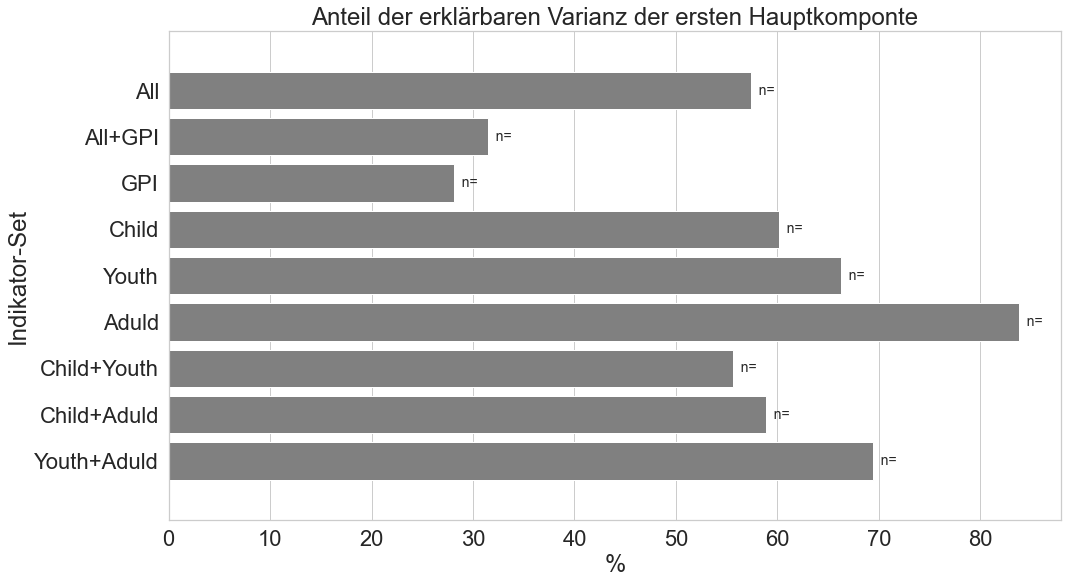

In [56]:
#https://stackoverflow.com/questions/68616781/customizing-the-hue-colors-used-in-seaborn-barplot
palette = {
    'All': 'tab:grey',
    'Rural': 'tab:orange',
    'Urban': 'tab:blue'
}

order = ["All", "All+GPI", "GPI", "Child", "Youth", "Aduld", "Child+Youth","Child+Aduld", "Youth+Aduld"]

pca_results["transformation"] = pca_results["transformation"].fillna("none")
pca_results["Type of place of residence"] = pca_results["Type of place of residence"].fillna("All")

combinations = pca_results[(pca_results["Imputation"]==False)&(pca_results["transformation"]=="none")&(pca_results["outlier_transformation"]=="zscore")].sort_values(by="Explained variance PC1", ascending=False).round(3)
combinations['Feature Name'] = combinations['Feature No.'].replace([0,1,2,3,4,5,6,7,8], ["Child+Youth","Child+Aduld" ,"Child", "Youth", "Aduld", "All", "Youth+Aduld", "All+GPI", "GPI"])
combinations['Type of place of residence'] = combinations['Type of place of residence'].replace(["None", "urban", "rural"], ["Female", "Urban", "Rural"])

combinations["Features"] = pd.Categorical(combinations["Feature Name"], categories = order)
labels = combinations[["Features", "Observations"]].sort_values(by=["Features"])["Observations"].values

# plot
sns.set(font_scale=2)
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(16, 9))

sns.set(font_scale=2)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.barplot(y=combinations["Feature Name"].rename("Indikator-Set"), x=combinations["Explained variance PC1"].apply(lambda x: x*100).rename("%"), order=order, color='grey', ax=ax, dodge=True, orient="h").set(title="Anteil der erklärbaren Varianz der ersten Hauptkomponte")

# https://stackoverflow.com/questions/63220741/how-to-plot-and-annotate-grouped-bars-in-seaborn-matplotlib
padding=0
for c, label in zip(ax.containers, labels):

    # set the bar label    
    ax.bar_label(c, fmt=f"""  n= """, label_type='edge', padding=padding, fontsize=14)
 
    # pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

In [57]:
combinations[(combinations["Type of place of residence"]=="All")]#.to_csv(r"C:\Users\julii\Downloads\PCA_Komponenten.csv")

Features  Feature No.  Observations Type of place of residence  Imputation outlier_transformation transformation  Explained variance PC1  Explained variance PC2  Skewness  Kurtosis Feature Name
4        Aduld            4         30924                        All       False                 zscore           none                   0.838                   0.114     0.398    -0.958        Aduld
6  Youth+Aduld            6         29843                        All       False                 zscore           none                   0.694                   0.119     0.330    -0.915  Youth+Aduld
3        Youth            3         30239                        All       False                 zscore           none                   0.663                   0.188     0.287    -0.677        Youth
2        Child            2         30174                        All       False                 zscore           none                   0.602                   0.277     0.688    -0.105        Child
1  Child+Aduld            1         28911                        All       False                 zscore           none                   0.589                   0.168    -0.115    -0.827  Child+Aduld
5          All            5         28596                        All       False                 zscore           none                   0.574                   0.146    -0.048    -0.872          All
0  Child+Youth            0         28918                        All       False                 zscore           none                   0.556                   0.209    -0.350    -0.627  Child+Youth
7      All+GPI            7          7319                        All       False                 zscore           none                   0.315                   0.137     0.556    -0.054      All+GPI
8          GPI            8          7599                        All       False                 zscore           none                   0.281                   0.185     0.473     0.362          GPI

### PCA

In [58]:
def run_pca(df, feature_set, cols):

    # MinMaxScaler erstellen
    scaler = MinMaxScaler()
    
    df_pca = df.dropna(subset=feature_set)

    # Separating out the features
    x = df_pca.loc[:, feature_set].values

    # Separating out the target
    y = df_pca.loc[:, cols].values

    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    # apply the pca analysis
    pca_female = PCA(n_components=2)
    principalComponents = pca_female.fit_transform(x)

    principalDf_female = pd.DataFrame(data = principalComponents
                                                     , columns = ['principal component 1', 'principal component 2'])

    finalDf_female = pd.concat([pd.DataFrame(principalDf_female), df_pca[cols + ["Observations", "Imputed"]].reset_index(drop=True)], axis = 1).drop_duplicates()
    finalDf_female["HV025: Type of place of residence"].rename("Type of place of residence", inplace=True)

    # Min-Max-Skalierung auf die ausgewählte Spalte anwenden
    finalDf_female["principal component 1 (min-max-scaled)"] = scaler.fit_transform(finalDf_female[["principal component 1"]])

    print('variance ratio', pca_female.explained_variance_ratio_)

    data = finalDf_female['principal component 1'].values  # Deine Daten hier
    stat, p_value = shapiro(data)

    print("Statistik:", round(stat, 3))
    print("p-Wert:", round(p_value, 20))

    print("Count:", finalDf_female["principal component 1 (min-max-scaled)"].count())
    print("Skewness:", finalDf_female["principal component 1 (min-max-scaled)"].skew())
    print("Kurtosis:", finalDf_female["principal component 1 (min-max-scaled)"].kurtosis())
    print("Min:", finalDf_female["principal component 1 (min-max-scaled)"].min())
    print("Max:", round(finalDf_female["principal component 1 (min-max-scaled)"].max(), 20))
    print("Mean:", round(finalDf_female["principal component 1 (min-max-scaled)"].mean(), 20))
    print("Median:", round(finalDf_female["principal component 1 (min-max-scaled)"].median(), 20))
    print("Standartabweichung:", finalDf_female["principal component 1 (min-max-scaled)"].std())
    print("Varianz:", finalDf_female["principal component 1 (min-max-scaled)"].var())

    print("\nRural")
    print("Count:", finalDf_female[finalDf_female["HV025: Type of place of residence"]=="rural"]["principal component 1 (min-max-scaled)"].count())    
    print("Mean:", finalDf_female[finalDf_female["HV025: Type of place of residence"]=="rural"]["principal component 1 (min-max-scaled)"].mean())
    print("Median:", finalDf_female[finalDf_female["HV025: Type of place of residence"]=="rural"]["principal component 1 (min-max-scaled)"].median())
    print("Skewness:", finalDf_female[finalDf_female["HV025: Type of place of residence"]=="rural"]["principal component 1 (min-max-scaled)"].skew())
    print("Kurtosis:", finalDf_female[finalDf_female["HV025: Type of place of residence"]=="rural"]["principal component 1 (min-max-scaled)"].kurtosis())
    print("Min:", finalDf_female[finalDf_female["HV025: Type of place of residence"]=="rural"]["principal component 1 (min-max-scaled)"].min())
    print("Max:", round(finalDf_female[finalDf_female["HV025: Type of place of residence"]=="rural"]["principal component 1 (min-max-scaled)"].max(), 20))
       
    print("\nUrban")
    print("Count:", finalDf_female[finalDf_female["HV025: Type of place of residence"]=="urban"]["principal component 1 (min-max-scaled)"].count())    
    print("Mean:", finalDf_female[finalDf_female["HV025: Type of place of residence"]=="urban"]["principal component 1 (min-max-scaled)"].mean())
    print("Median:", finalDf_female[finalDf_female["HV025: Type of place of residence"]=="urban"]["principal component 1 (min-max-scaled)"].median())
    print("Skewness:", finalDf_female[finalDf_female["HV025: Type of place of residence"]=="urban"]["principal component 1 (min-max-scaled)"].skew())
    print("Kurtosis:", finalDf_female[finalDf_female["HV025: Type of place of residence"]=="urban"]["principal component 1 (min-max-scaled)"].kurtosis())
    print("Min:", finalDf_female[finalDf_female["HV025: Type of place of residence"]=="urban"]["principal component 1 (min-max-scaled)"].min())
    print("Max:", round(finalDf_female[finalDf_female["HV025: Type of place of residence"]=="urban"]["principal component 1 (min-max-scaled)"].max(), 20))
    
    
    return finalDf_female

### PCA - Female Education Index

In [59]:
df, indikators, features = create_sub_samples(max_missing_per_row=0.3, outlier_transformation="zscore", transformation=None, indikators="female$", min_oberservations=10, split_place=None)
df_gpi, indikators_gpi, features_gpi = create_sub_samples(max_missing_per_row=0.3, outlier_transformation="zscore", transformation=None, indikators="female$|GPI$", min_oberservations=10, split_place=None)

cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
  
female_sets = [['ExpectedYearsOfSchooling_female',
 'GrossPrimaryEnrollmentRate_female',
 'NetPrimaryEnrollmentRate_female',
 'GrossSecondaryEnrollmentRate_female',
 'NetSecondaryEnrollmentRate_female', 
 'YouthLiteracyRate_female',
 'YouthPrimaryGraduationRate_female',
 'YouthSecondaryGraduationRate_female',
 'MeanYearsOfSchooling_female',
 'AduldLiteracyRate_female',
 'AduldPrimaryGraduationRate_female',
 'AduldSecondaryGraduationRate_female'],
 ['ExpectedYearsOfSchooling_female_imputed',
 'GrossPrimaryEnrollmentRate_female_imputed',
 'NetPrimaryEnrollmentRate_female_imputed',
 'GrossSecondaryEnrollmentRate_female_imputed',
 'NetSecondaryEnrollmentRate_female_imputed', 
 'YouthLiteracyRate_female_imputed',
 'YouthPrimaryGraduationRate_female_imputed',
 'YouthSecondaryGraduationRate_female_imputed',
 'MeanYearsOfSchooling_female_imputed',
 'AduldLiteracyRate_female_imputed',
 'AduldPrimaryGraduationRate_female_imputed',
 'AduldSecondaryGraduationRate_female_imputed'],
 ['ExpectedYearsOfSchooling_female', 
 'GrossPrimaryEnrollmentRate_female',
 'NetPrimaryEnrollmentRate_female',
 'GrossSecondaryEnrollmentRate_female',
 'NetSecondaryEnrollmentRate_female',
 'YouthLiteracyRate_female',
 'YouthPrimaryGraduationRate_female',
 'YouthSecondaryGraduationRate_female',
 'MeanYearsOfSchooling_female',
 'AduldLiteracyRate_female',
 'AduldPrimaryGraduationRate_female',
 'AduldSecondaryGraduationRate_female',
 'ExpectedYearsOfSchooling_GPI',
 'GrossPrimaryEnrollmentRate_GPI',
 'NetPrimaryEnrollmentRate_GPI',
 'GrossSecondaryEnrollmentRate_GPI',
 'NetSecondaryEnrollmentRate_GPI',
 'YouthLiteracyRate_GPI',
 'YouthPrimaryGraduationRate_GPI',
 'YouthSecondaryGraduationRate_GPI',
 'MeanYearsOfSchooling_GPI',
 'AduldLiteracyRate_GPI',
 'AduldPrimaryGraduationRate_GPI',
 'AduldSecondaryGraduationRate_GPI'],    
['ExpectedYearsOfSchooling_GPI',
 'GrossPrimaryEnrollmentRate_GPI',
 'NetPrimaryEnrollmentRate_GPI',
 'GrossSecondaryEnrollmentRate_GPI',
 'NetSecondaryEnrollmentRate_GPI', 
 'YouthLiteracyRate_GPI',
 'YouthPrimaryGraduationRate_GPI',
 'YouthSecondaryGraduationRate_GPI',
 'MeanYearsOfSchooling_GPI',
 'AduldLiteracyRate_GPI',
 'AduldPrimaryGraduationRate_GPI',
 'AduldSecondaryGraduationRate_GPI']]

data = run_pca(df=df, feature_set=female_sets[0], cols=cols)
data_imputed = run_pca(df=df, feature_set=female_sets[1], cols=cols)   
data_gpi_female = run_pca(df=df_gpi, feature_set=female_sets[2], cols=cols)
data_gpi = run_pca(df=df_gpi, feature_set=female_sets[3], cols=cols)  

variance ratio [0.57379531 0.14606394]
Statistik: 0.981
p-Wert: 0.0
Count: 28596
Skewness: -0.04788075553901017
Kurtosis: -0.8717425927528768
Min: 0.0
Max: 1.0
Mean: 0.44285210129108704
Median: 0.4471515594251085
Standartabweichung: 0.2283049340810252
Varianz: 0.05212314292574126

Rural
Count: 18260
Mean: 0.3675289880728723
Median: 0.3615213401798246
Skewness: 0.2205127920749269
Kurtosis: -0.7520032575337656
Min: 0.0
Max: 0.9557671544920034

Urban
Count: 10336
Mean: 0.5759209913224779
Median: 0.5939188167033701
Skewness: -0.43370894581999947
Kurtosis: -0.26250745838346834
Min: 0.0
Max: 1.0
variance ratio [0.57343068 0.14994444]
Statistik: 0.982
p-Wert: 0.0
Count: 31352
Skewness: -0.05156325419670288
Kurtosis: -0.8548566541636671
Min: 0.0
Max: 1.0
Mean: 0.4470290231649668
Median: 0.4521783344305279
Standartabweichung: 0.22624458872932382
Varianz: 0.051186613929300885

Rural
Count: 19596
Mean: 0.36770055339763297
Median: 0.3618942998914429
Skewness: 0.21237397279826462
Kurtosis: -0.74697

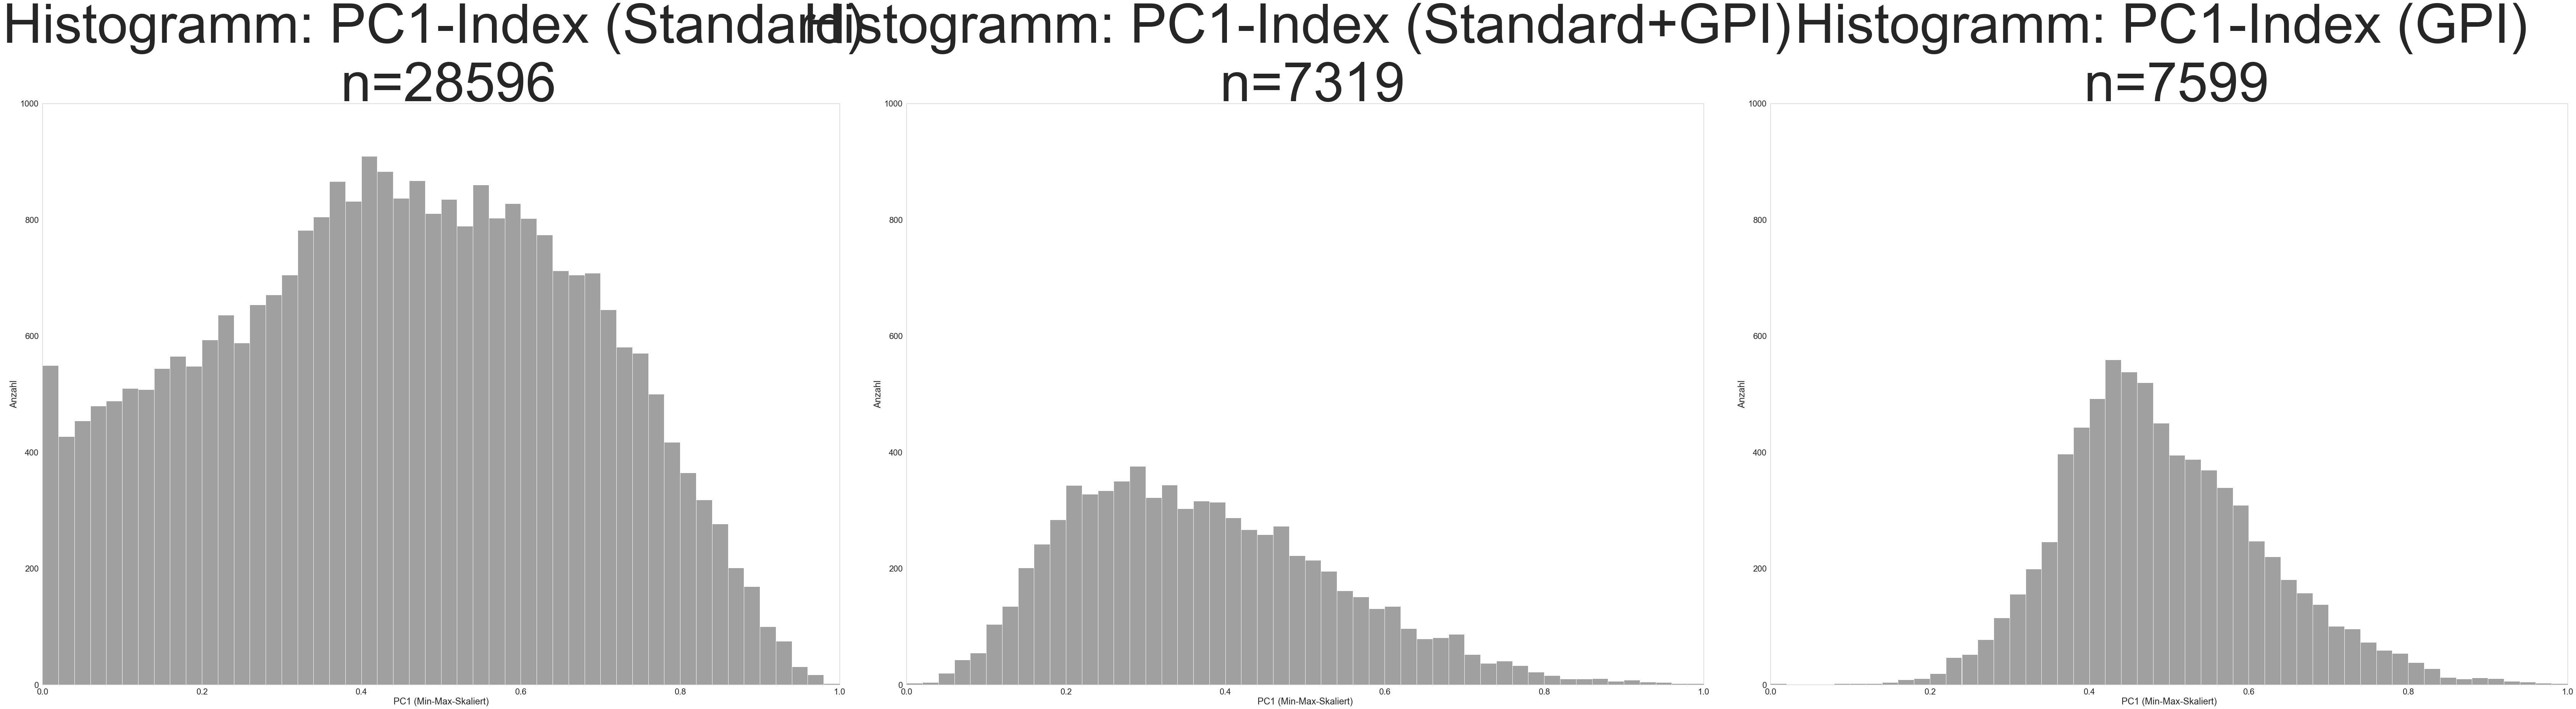

In [60]:
palette = {
    "rural": 'tab:orange',
    "urban": 'tab:blue',
}

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(96, 25)
fig.tight_layout(pad=5.0)

sns.set(font_scale=12, rc={'figure.figsize':(96, 25)})
sns.set_style("whitegrid", {'axes.grid' : False})

sns.histplot(palette=palette, bins=50, data=data, x=data["principal component 1 (min-max-scaled)"].rename("PC1 (Min-Max-Skaliert)"), kde=False, color="grey", ax = axes[0]).set(title=f"Histogramm: PC1-Index (Standard) \n n={len(data.index)}", ylabel='Anzahl', ylim=(0, 1000), xlim=(0, 1))
#sns.histplot(palette=palette, bins=50, data=data, x=data["principal component 1 (min-max-scaled)"].rename("PC1 (Min-Max-Skaliert)"), hue_order=["urban", "rural"], hue=data["HV025: Type of place of residence"].rename(""), kde=False, color="skyblue", ax = axes[0,1]).set(title=f"Histogramm: PC1-Index (Standard) nach Art des Wohnortes \n n={len(data.index)}", ylabel='Anzahl', ylim=(0, 1000), xlim=(0, 1))

sns.histplot(palette=palette, bins=50, data=data_gpi_female, x=data_gpi_female["principal component 1 (min-max-scaled)"].rename("PC1 (Min-Max-Skaliert)"), kde=False, color="grey", ax = axes[1]).set(title=f"Histogramm: PC1-Index (Standard+GPI) \n n={len(data_gpi_female.index)}", ylabel='Anzahl', ylim=(0, 1000), xlim=(0, 1))
#sns.histplot(palette=palette, bins=50, data=data_gpi_female, x=data_gpi_female["principal component 1 (min-max-scaled)"].rename("PC1 (Min-Max-Skaliert)"), hue_order=["urban", "rural"], hue=data_gpi_female["HV025: Type of place of residence"].rename(""), kde=False, color="skyblue", ax = axes[1,1]).set(title=f"Histogramm: PC1-Index (Standard+GPI) nach Art des Wohnortes \n n={len(data_gpi_female.index)}", ylabel='Anzahl', ylim=(0, 1000), xlim=(0, 1))

sns.histplot(palette=palette, bins=50, data=data_gpi, x=data_gpi["principal component 1 (min-max-scaled)"].rename("PC1 (Min-Max-Skaliert)"), kde=False, color="grey", ax = axes[2]).set(title=f"Histogramm: PC1-Index (GPI) \n n={len(data_gpi.index)}", ylabel='Anzahl', ylim=(0, 1000), xlim=(0, 1))
#sns.histplot(palette=palette, bins=50, data=data_gpi, x=data_gpi["principal component 1 (min-max-scaled)"].rename("PC1 (Min-Max-Skaliert)"), hue_order=["urban", "rural"], hue=data_gpi["HV025: Type of place of residence"].rename(""), kde=False, color="skyblue", ax = axes[2,1]).set(title=f"Histogramm: PC1-Index (GPI) nach Art des Wohnortes \n n={len(data_gpi.index)}", ylabel='Anzahl', ylim=(0, 1000), xlim=(0, 1))

plt.show()

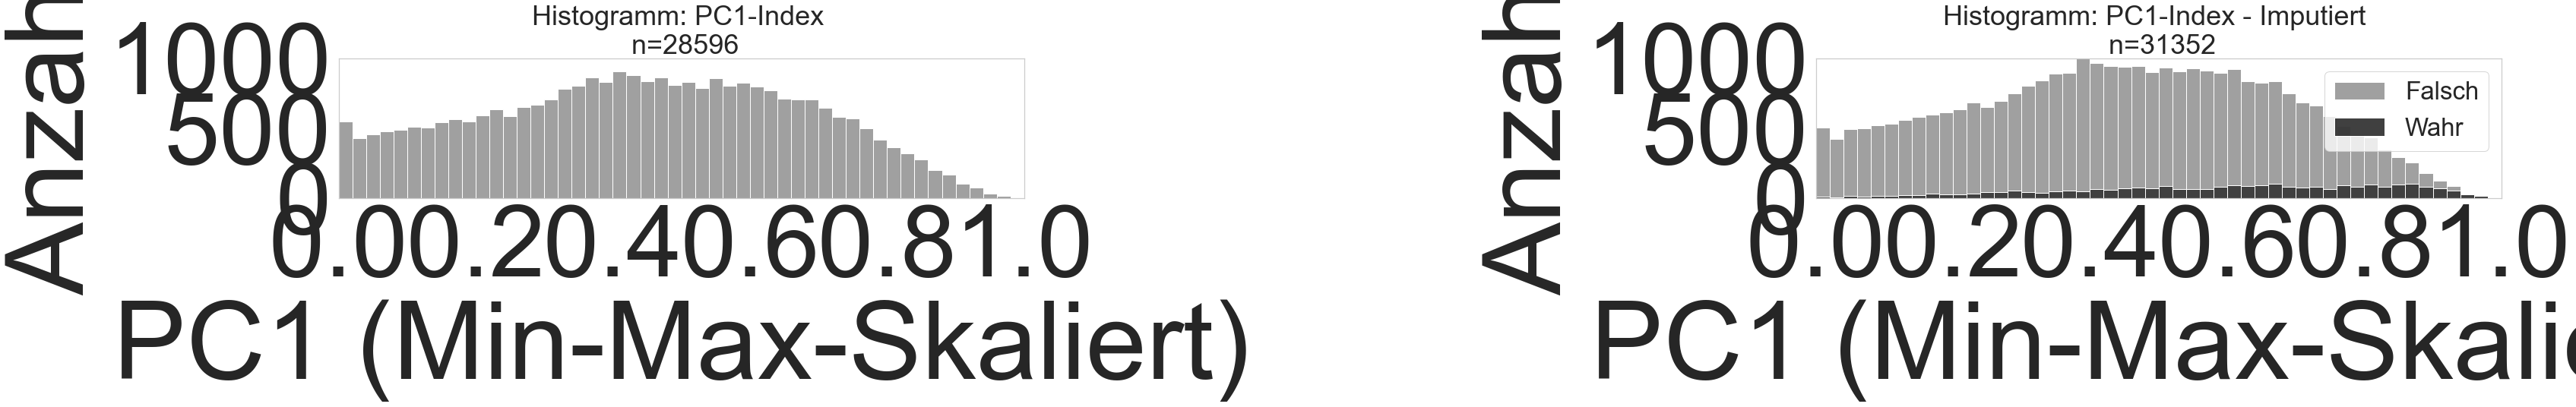

In [61]:
palette = {
    "True": 'tab:black',
    "False": 'tab:orange',
}

palette2 = {
    "rural": 'tab:orange',
    "urban": 'tab:blue',
}

fig2, axes2 = plt.subplots(1, 2)
fig2.set_size_inches(64, 25)
fig2.tight_layout(pad=5.0)

sns.set(font_scale=3, rc={'figure.figsize':(64, 25)})
sns.set_style("whitegrid", {'axes.grid' : False})

sns.histplot(bins=50, palette=palette2, data=data, x=data["principal component 1 (min-max-scaled)"].rename("PC1 (Min-Max-Skaliert)"), kde=False, color="grey", ax = axes2[0]).set(title=f"Histogramm: PC1-Index \n n={len(data.index)}", ylabel='Anzahl', ylim=(0, 1000), xlim=(0, 1))
#sns.histplot(bins=50, hue_order=["urban", "rural"], palette=palette2, data=data, x=data["principal component 1 (min-max-scaled)"].rename("PC1 (Min-Max-Skaliert)"), hue=data["HV025: Type of place of residence"].rename(""), kde=False, color="skyblue", ax = axes2[0,1]).set(title=f"Histogramm: PC1-Index nach Art des Wohnortes \n n={len(data_imputed.index)}", ylabel='Anzahl', ylim=(0, 1000), xlim=(0, 1))

sns.histplot(bins=50, stat="count", multiple="stack", hue=data_imputed['Imputed'].replace(["True", "False"], ["Wahr", "Falsch"]).rename(""), data=data_imputed, x=data_imputed["principal component 1 (min-max-scaled)"].rename("PC1 (Min-Max-Skaliert)"), kde=False, palette=["grey", "black"], ax = axes2[1]).set(title=f"Histogramm: PC1-Index - Imputiert \n n={len(data_imputed.index)}", ylabel='Anzahl', ylim=(0, 1000), xlim=(0, 1))
#sns.histplot(bins=50, hue_order=["urban", "rural"], palette=palette2, data=data_imputed, x=data_imputed["principal component 1 (min-max-scaled)"].rename("PC1 (Min-Max-Skaliert)"), legend=False, hue=data_imputed["HV025: Type of place of residence"].rename(""), kde=False, color="skyblue", ax = axes2[1,1]).set(title=f"Histogramm: PC1-Index nach Art des Wohnortes \n n={len(data_imputed.index)}", ylabel='Anzahl', ylim=(0, 1000), xlim=(0, 1))

#sns.histplot(bins=50, hue=data_imputed[(data_imputed["Imputed"]=="True")]['HV025: Type of place of residence'].replace(["urban", "rural"], ["Urban - imputiert", "Rural - imputiert"]).rename(""), data=data_imputed[(data_imputed["Imputed"]=="True")], x=data_imputed[(data_imputed["Imputed"]=="True")]["principal component 1 (min-max-scaled)"].rename("Index"), kde=False, palette=[sns.color_palette("dark")[0], sns.color_palette("dark")[1]], ax = axes2[1,1]).set(title=f"Histogramm: PC1-Index nach Art des Wohnortes - Imputiert \n n={len(data_imputed.index)}", ylabel='Anzahl', ylim=(0, 1000), xlim=(0, 1))

plt.show()

In [62]:
from scipy.stats import ttest_ind

rvs1 = data[data["HV025: Type of place of residence"]=="rural"]["principal component 1 (min-max-scaled)"]
rvs2 = data[data["HV025: Type of place of residence"]=="urban"]["principal component 1 (min-max-scaled)"]

t_stat, p_value = ttest_ind(rvs2, rvs1, equal_var=False)
t_stat, p_value

(85.43942345364746, 0.0)

In [63]:
from scipy.stats import ttest_ind

rvs1 = data_imputed[data_imputed["HV025: Type of place of residence"]=="rural"]["principal component 1 (min-max-scaled)"]
rvs2 = data_imputed[data_imputed["HV025: Type of place of residence"]=="urban"]["principal component 1 (min-max-scaled)"]

t_stat, p_value = ttest_ind(rvs2, rvs1, equal_var=False)
t_stat, p_value

(92.47534823692703, 0.0)

#### Korrelationsmatrix

<Axes: >

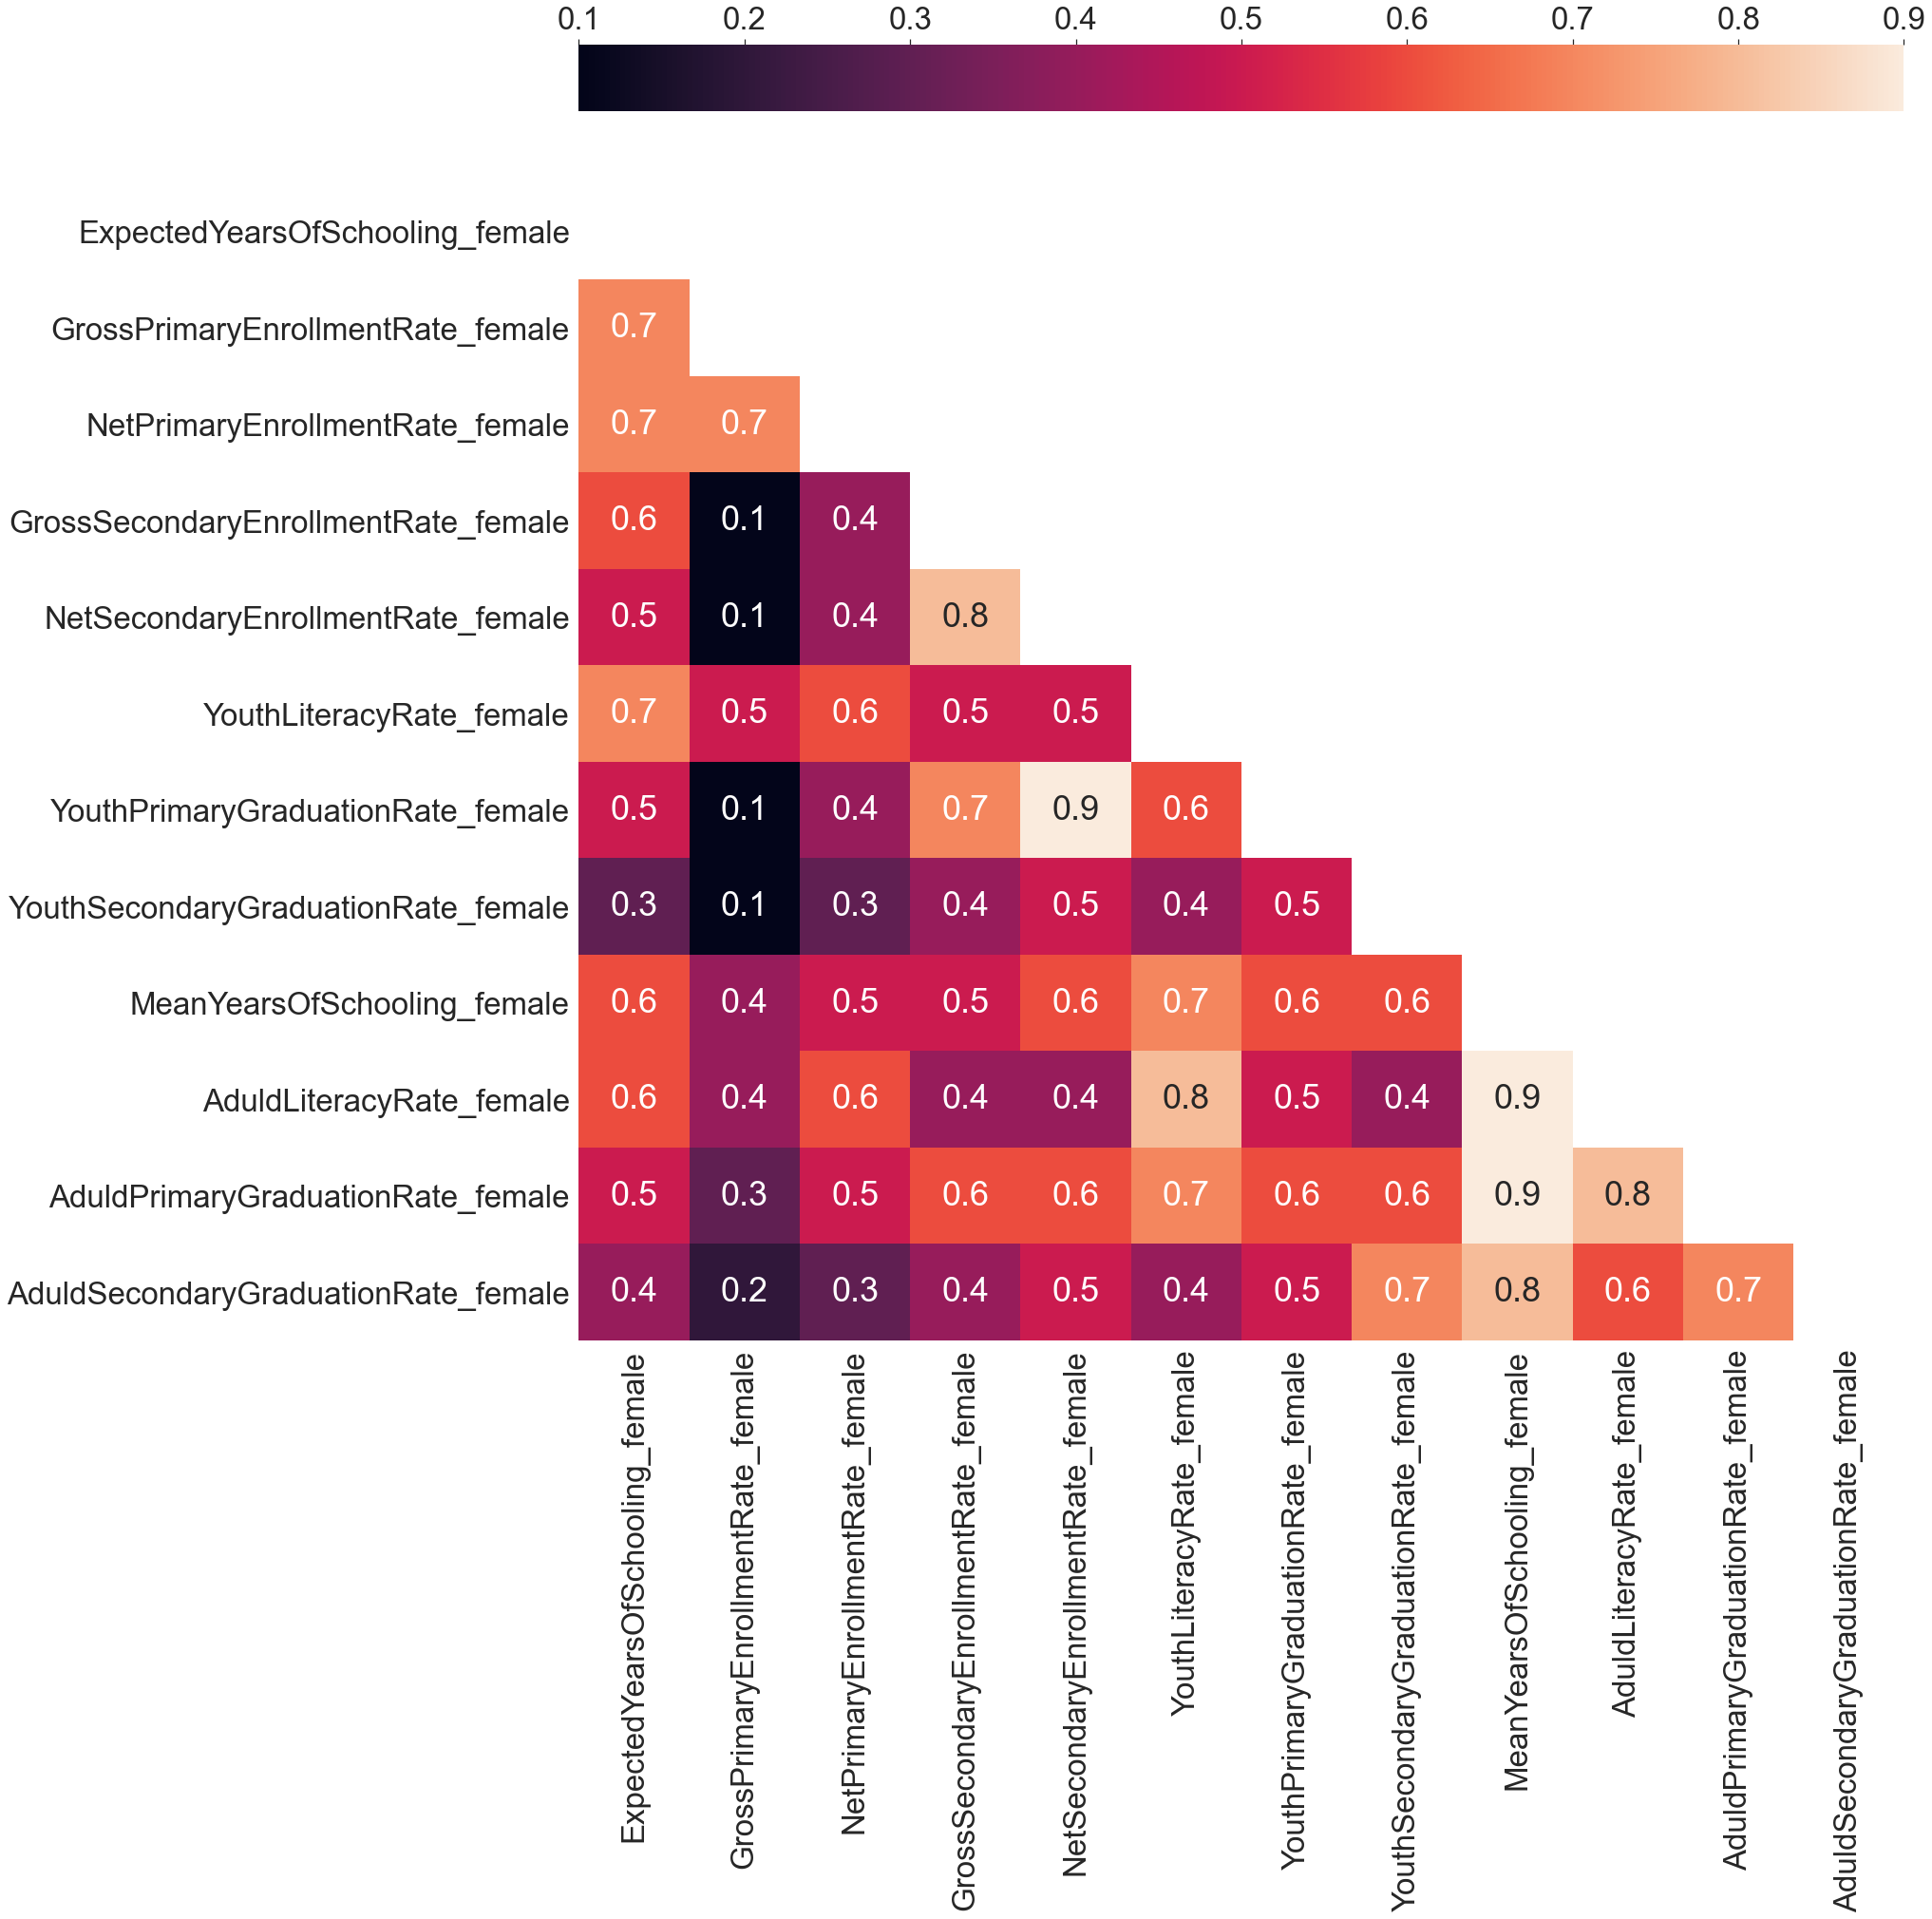

In [64]:
sns.set(font_scale=3, rc={'figure.figsize':(25,28)})
sns.set_style("whitegrid", {'axes.grid' : False})

# define the mask to set the values in the upper triangle to True
#mask = np.triu(np.ones_like(df[features[:12]].dropna().corr().round(3)))
#sns.heatmap(df[features[:12]].dropna().corr().round(3), annot=True, mask=mask, cbar=False)#.set(title="Korrelationsmatrix der Indikatoren")

mask = np.triu(np.ones_like(df[features[:12]].dropna().corr().round(3)))
sns.heatmap(df[features[:12]].dropna().corr().round(1), annot=True, mask=mask, cbar_kws = dict(use_gridspec=False,location="top"))#.set(title="Korrelationsmatrix der Indikatoren") 

#### Biplot

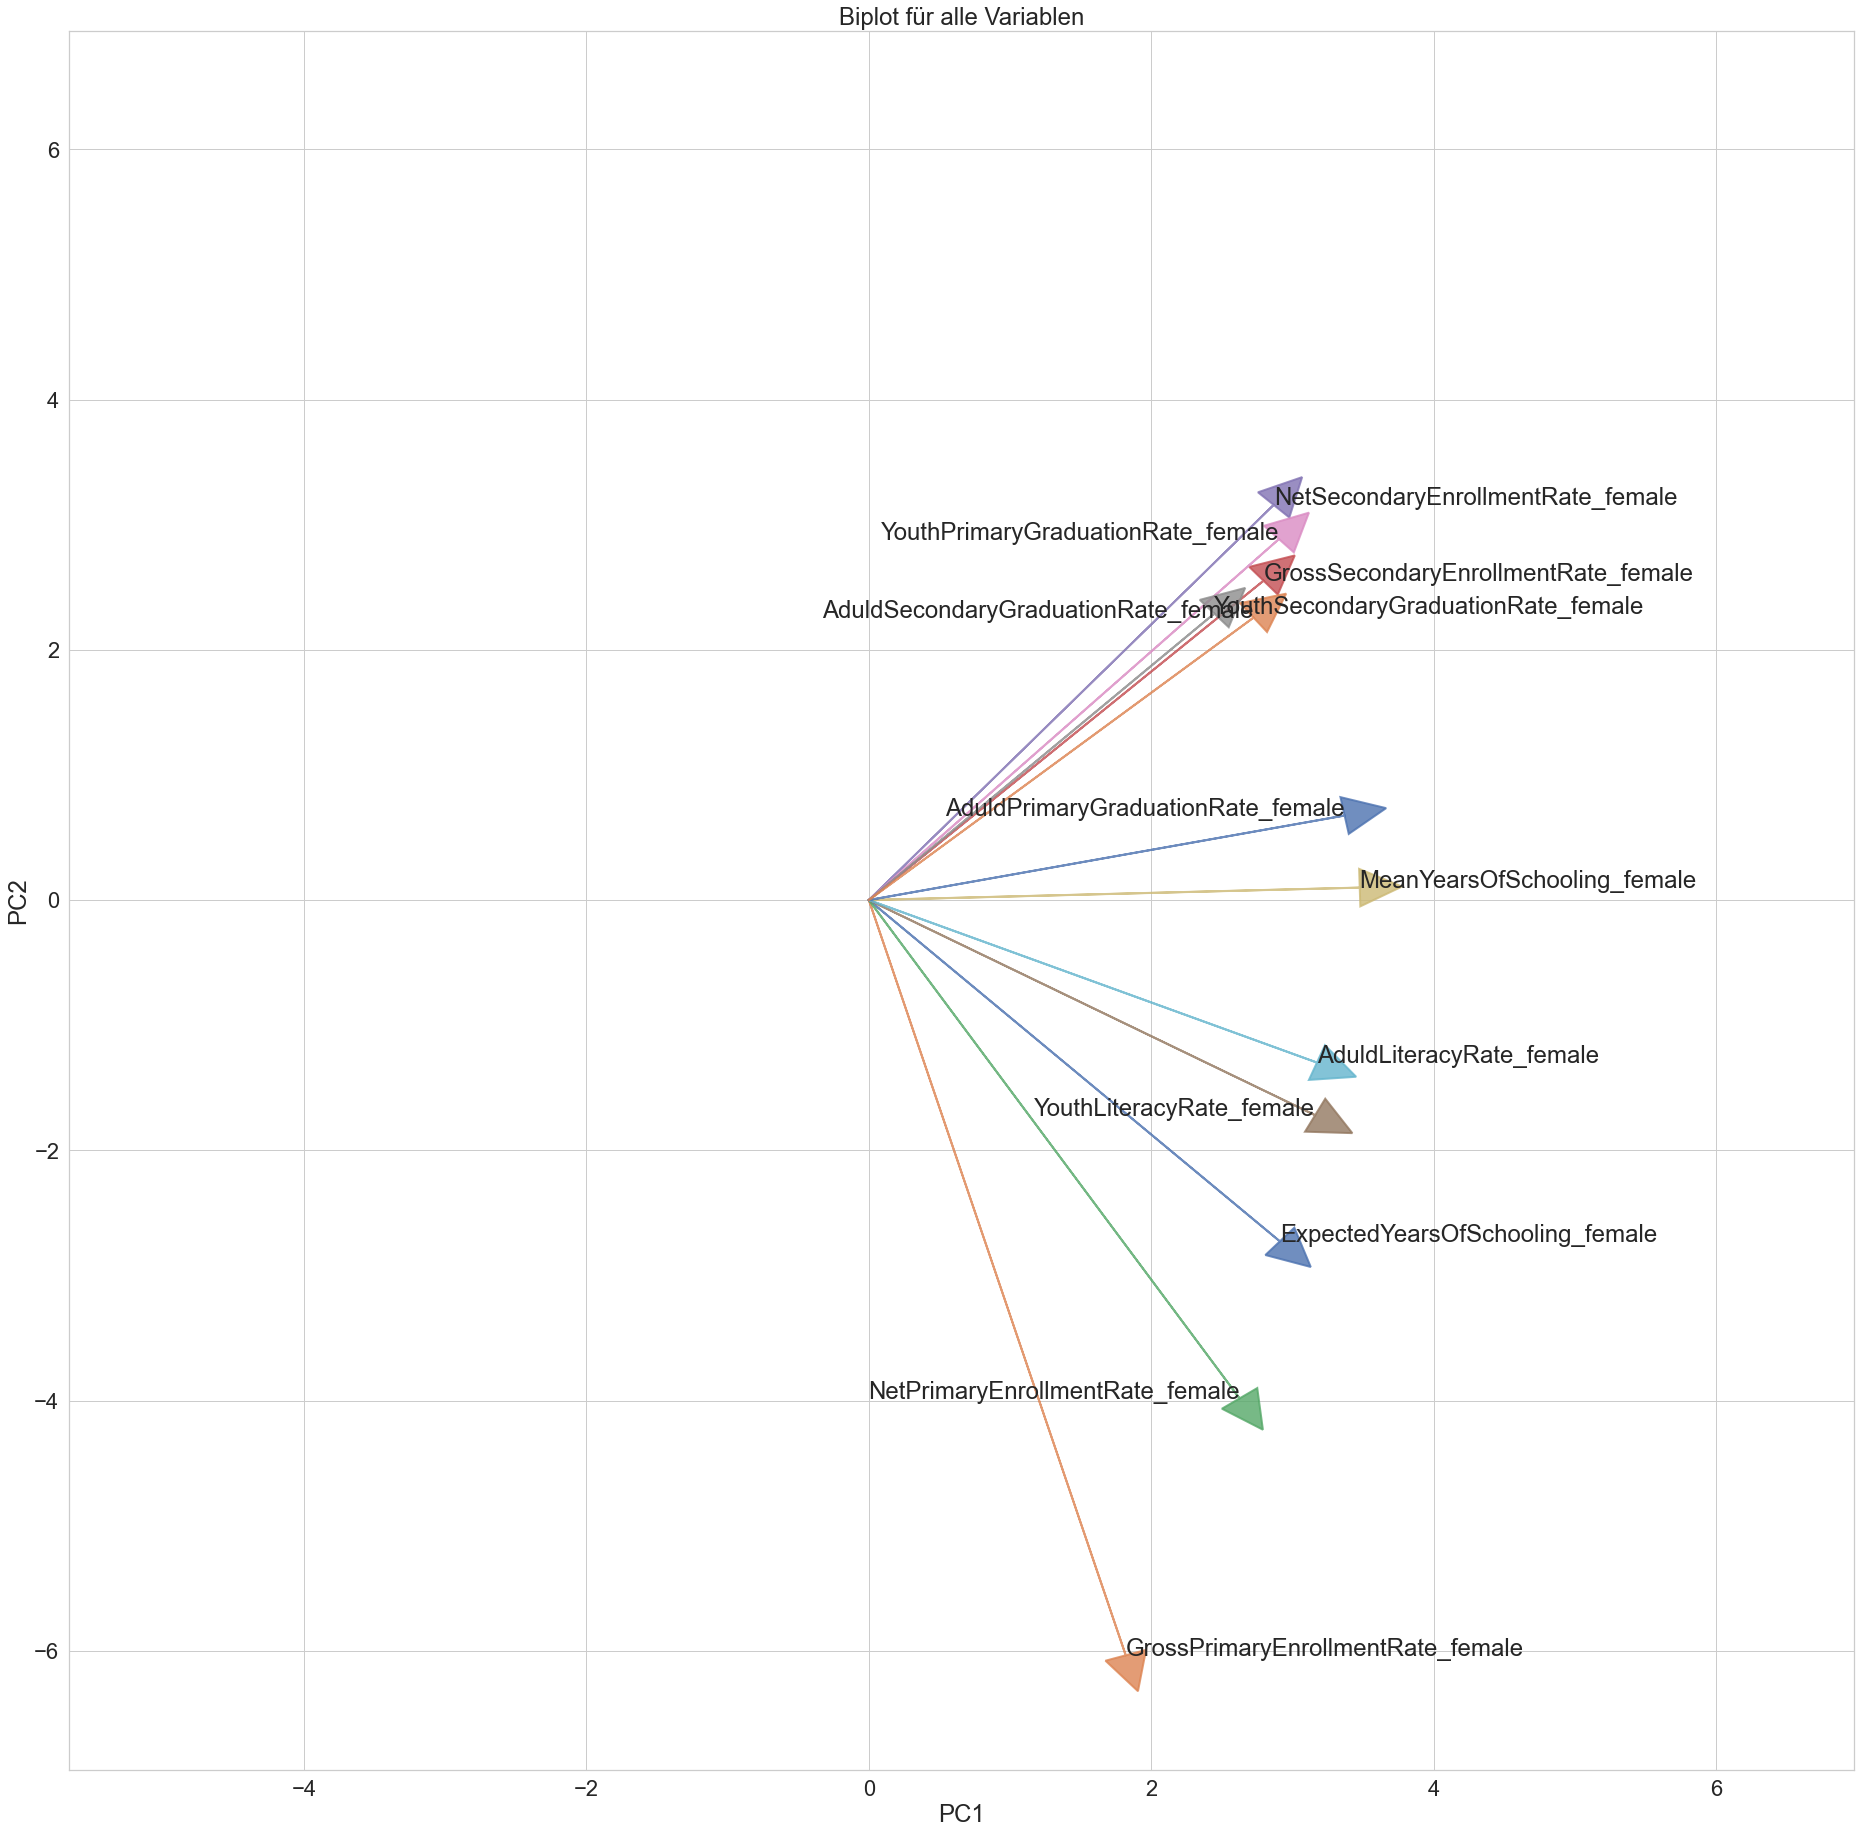

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import datasets

df, indikators, features = create_sub_samples(max_missing_per_row=0.3, outlier_transformation="zscore", transformation=None, indikators="female$", min_oberservations=10, split_place=None)

feature_set = ['ExpectedYearsOfSchooling_female',
 'GrossPrimaryEnrollmentRate_female',
 'NetPrimaryEnrollmentRate_female',
 'GrossSecondaryEnrollmentRate_female',
 'NetSecondaryEnrollmentRate_female', 
 'YouthLiteracyRate_female',
 'YouthPrimaryGraduationRate_female',
 'YouthSecondaryGraduationRate_female',
 'MeanYearsOfSchooling_female',
 'AduldLiteracyRate_female',
 'AduldPrimaryGraduationRate_female',
 'AduldSecondaryGraduationRate_female'] 

abb = ['EYS', 'GPE', 'NPE', 'GSE', 'NSE', 'YLR', 'YPG', 'YSG', 'MYS', 'ALR', 'APG', 'ASG'] 

X = df.dropna(subset=feature_set).loc[:, feature_set].values
y = df.dropna(subset=feature_set).loc[:, cols].values

# Standardisierung der Merkmale
X_scaled = StandardScaler().fit_transform(X)

# Durchführung der Hauptkomponentenanalyse (PCA)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Erstellen eines Pandas DataFrame für die Biplot-Funktion von seaborn
components_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Biplot mit seaborn erstellen
sns.set(style="whitegrid")
sns.set(font_scale=2, rc={'figure.figsize':(32,32)})
sns.set_style("whitegrid")

# Scatterplot mit den Hauptkomponenten
sns.scatterplot(x='PC1', y='PC2', data=components_df, palette='viridis', alpha=0.0)

# Pfeile für die Beiträge der Merkmale zu den Hauptkomponenten
scale = 10
feature_vectors = pca.components_.T

for i, v in enumerate(feature_vectors):
    plt.arrow(0, 0, v[0]*scale, v[1]*scale, head_width=0.3, head_length=0.3, linewidth=2, color=f'C{i}', alpha=0.8)    
    if i in [2,5,6,10,11]:
        plt.text(v[0]*scale, v[1]*scale, f'{feature_set[i]}', ha='right')
    else:
        plt.text(v[0]*scale, v[1]*scale, f'{feature_set[i]}', ha='left')

plt.title('Biplot für alle Variablen')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [66]:
# merge with dhs location data
all_locations_final = pd.read_csv(projects_p + '/ressources/locations.csv')

final = data_imputed.copy()
final.insert(0, 'DHSID', final["HV000: country code"]+final["HV007: year of interview"].apply(lambda x: str(x)[:4])+final["HV001: cluster number"].apply(lambda x: str(int(x)).rjust(8, "0")))        
final = final.merge(all_locations_final[['DHSID', 'DHSYEAR', 'URBAN_RURA', 'LATNUM', 'LONGNUM', 'GEID', 'adm2_name','adm1_name', 'adm0_name']], on='DHSID', how='left')   
final["adm1_name"] = final["adm1_name"].apply(lambda x: str(x).split("/")[0])

### Child Education Index

variance ratio [0.6024765  0.27711434]
Statistik: 0.956
p-Wert: 0.0
Count: 30172
Skewness: 0.6886164106046782
Kurtosis: -0.10451090760104176
Min: 0.0
Max: 1.0
Mean: 0.46317345563370554
Median: 0.4262440102568371
Standartabweichung: 0.20655318468667985
Varianz: 0.04266421810420968

Rural
Count: 19039
Mean: 0.5227096877313393
Median: 0.48854830442818803
Skewness: 0.4861039471109583
Kurtosis: -0.4938442759433621
Min: 0.03575357726822537
Max: 1.0

Urban
Count: 11133
Mean: 0.3613581028171342
Median: 0.3353014489895861
Skewness: 0.9774569417041042
Kurtosis: 1.327707292435683
Min: 0.0
Max: 1.0
variance ratio [0.59702983 0.28272425]
Statistik: 0.956
p-Wert: 0.0
Count: 31352
Skewness: 0.7017628877007186
Kurtosis: -0.06855280520570606
Min: 0.0
Max: 1.0
Mean: 0.4673579337401032
Median: 0.43187296307074097
Standartabweichung: 0.1974346386954994
Varianz: 0.03898043655682239

Rural
Count: 19596
Mean: 0.5242806970365773
Median: 0.490740136315419
Skewness: 0.4966969686857172
Kurtosis: -0.4750763615884

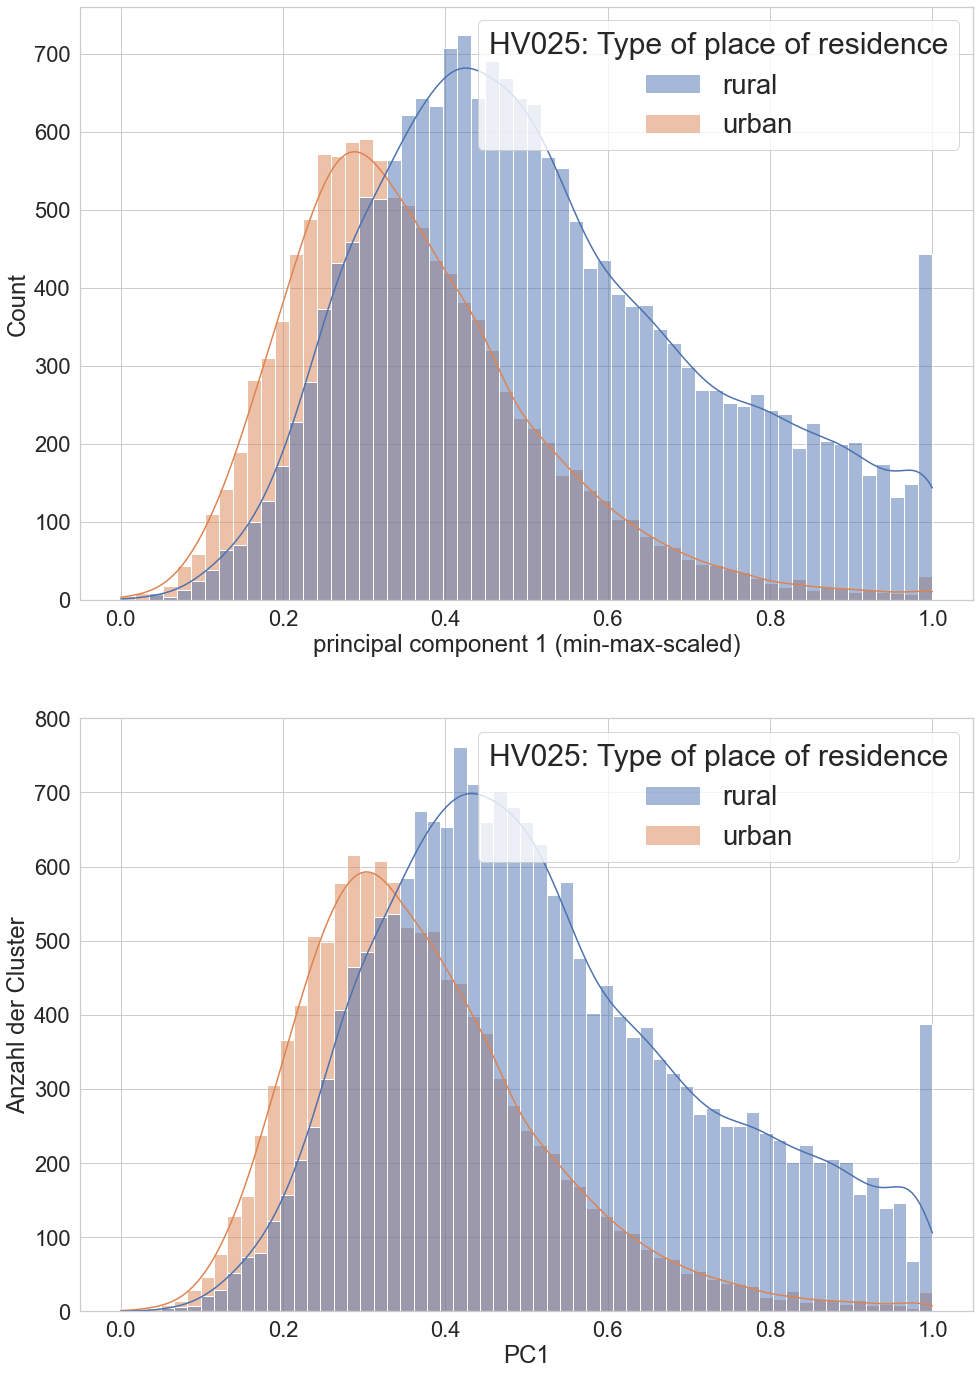

In [67]:
df, indikators, features = create_sub_samples(outlier_transformation="zscore", transformation=None, max_missing_per_row=0.3, indikators="female", min_oberservations=10, split_place=None)
cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
  
female_sets = [['ExpectedYearsOfSchooling_female',
 'GrossPrimaryEnrollmentRate_female',
 'NetPrimaryEnrollmentRate_female',
 'GrossSecondaryEnrollmentRate_female',
 'NetSecondaryEnrollmentRate_female'],
 ['ExpectedYearsOfSchooling_female_imputed',
 'GrossPrimaryEnrollmentRate_female_imputed',
 'NetPrimaryEnrollmentRate_female_imputed',
 'GrossSecondaryEnrollmentRate_female_imputed',
 'NetSecondaryEnrollmentRate_female_imputed']]
    
data_child = run_pca(df=df, feature_set=female_sets[0], cols=cols)
data_child_imputed = run_pca(df=df, feature_set=female_sets[1], cols=cols)   
    
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(16, 24)

sns.set(font_scale=2.5, rc={'figure.figsize':(16,9)})
sns.set_style("whitegrid", {'axes.grid' : False})

sns.histplot(data=data_child, x="principal component 1 (min-max-scaled)", hue="HV025: Type of place of residence", kde=True, color="skyblue", ax = axes[0])
sns.histplot(data=data_child_imputed, x="principal component 1 (min-max-scaled)", hue="HV025: Type of place of residence", kde=True, color="skyblue", ax = axes[1])

plt.xlabel('PC1')
plt.ylabel('Anzahl der Cluster')
    
plt.show()

### Youth Education Index

variance ratio [0.66068392 0.18987345]
Statistik: 0.972
p-Wert: 0.0
Count: 29664
Skewness: 0.29383684179616487
Kurtosis: -0.6527323041397413
Min: 0.0
Max: 1.0
Mean: 0.3847335677675082
Median: 0.3747507511013619
Standartabweichung: 0.2502438382113303
Varianz: 0.06262197856273843

Rural
Count: 18641
Mean: 0.306818857285417
Median: 0.280425017154908
Skewness: 0.6322666874397951
Kurtosis: -0.19043912856405276
Min: 0.0
Max: 1.0

Urban
Count: 11023
Mean: 0.5164951678851359
Median: 0.5139983004210413
Skewness: 0.0001149904798778185
Kurtosis: -0.39546598267499533
Min: 0.0
Max: 1.0
variance ratio [0.66378773 0.18996344]
Statistik: 0.973
p-Wert: 0.0
Count: 31352
Skewness: 0.28239496100808387
Kurtosis: -0.6611020543272934
Min: 0.0
Max: 1.0
Mean: 0.386836151671498
Median: 0.378612429898437
Standartabweichung: 0.23701441981590196
Varianz: 0.056175835200668614

Rural
Count: 19596
Mean: 0.3114041160780843
Median: 0.28925553470340043
Skewness: 0.6043494216397957
Kurtosis: -0.23640392286912926
Min: 0.0

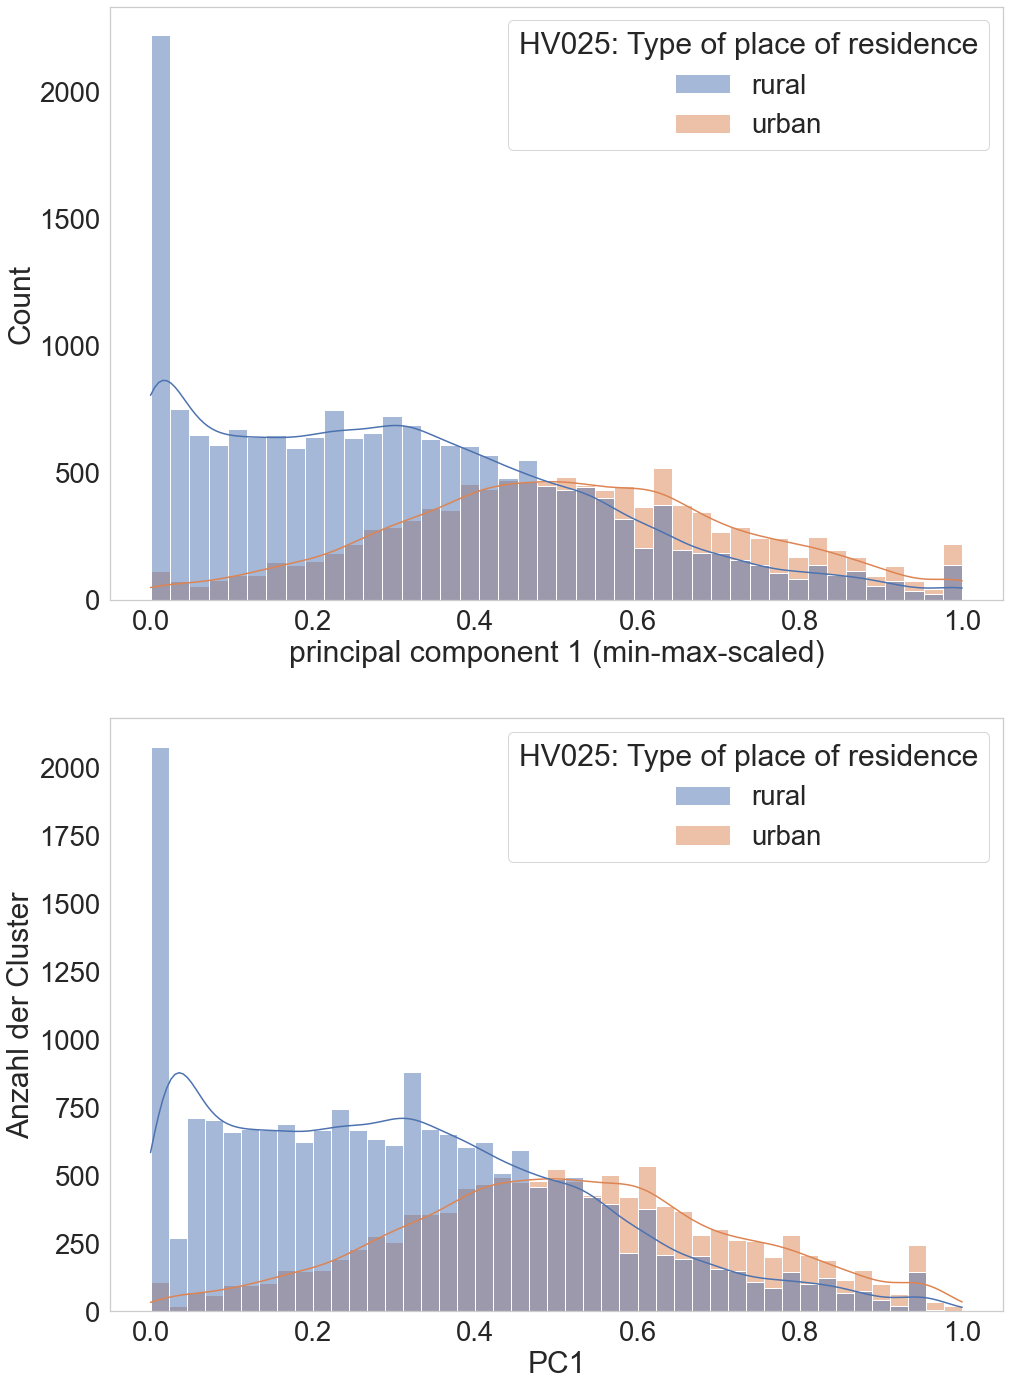

In [68]:
df, indikators, features = create_sub_samples(outlier_transformation="zscore", transformation=None, max_missing_per_row=0.3, indikators="female", min_oberservations=10, split_place=None)
cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
  
female_sets = [[
 'YouthLiteracyRate_female',
 'YouthPrimaryGraduationRate_female',
 'YouthSecondaryGraduationRate_female'],    
[ 'YouthLiteracyRate_female_imputed',
 'YouthPrimaryGraduationRate_female_imputed',
 'YouthSecondaryGraduationRate_female_imputed']]
    
data_youth = run_pca(df=df, feature_set=female_sets[0], cols=cols)
data_youth_imputed = run_pca(df=df, feature_set=female_sets[1], cols=cols)   
    
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(16, 24)

sns.set(font_scale=2.5, rc={'figure.figsize':(16,9)})
sns.set_style("whitegrid", {'axes.grid' : False})

sns.histplot(data=data_youth, x="principal component 1 (min-max-scaled)", hue="HV025: Type of place of residence", kde=True, color="skyblue", ax = axes[0])
sns.histplot(data=data_youth_imputed, x="principal component 1 (min-max-scaled)", hue="HV025: Type of place of residence", kde=True, color="skyblue", ax = axes[1])

plt.xlabel('PC1')
plt.ylabel('Anzahl der Cluster')
    
plt.show()




### Aduld Education Index

variance ratio [0.83756355 0.11502525]
Statistik: 0.938
p-Wert: 0.0
Count: 30039
Skewness: 0.4159310166455612
Kurtosis: -0.9312216550837529
Min: 0.0
Max: 1.0
Mean: 0.33405084422698467
Median: 0.30119092528690794
Standartabweichung: 0.2594230949122836
Varianz: 0.0673003421738677

Rural
Count: 18932
Mean: 0.2504322922139971
Median: 0.19810482827569814
Skewness: 0.7261930826491011
Kurtosis: -0.4641840967853099
Min: 0.0
Max: 0.9975336208532586

Urban
Count: 11107
Mean: 0.47657955825506526
Median: 0.4890782963175122
Skewness: -0.08989011495484808
Kurtosis: -0.993013661797808
Min: 0.0
Max: 1.0
variance ratio [0.84005778 0.11362662]
Statistik: 0.94
p-Wert: 0.0
Count: 31352
Skewness: 0.4286526375831402
Kurtosis: -0.8845794312004709
Min: 0.0
Max: 1.0
Mean: 0.3258185027591107
Median: 0.2959990748667831
Standartabweichung: 0.24482220275340896
Varianz: 0.059937910961031286

Rural
Count: 19596
Mean: 0.2437377497840408
Median: 0.19800091171505252
Skewness: 0.7220247861173773
Kurtosis: -0.43521716523

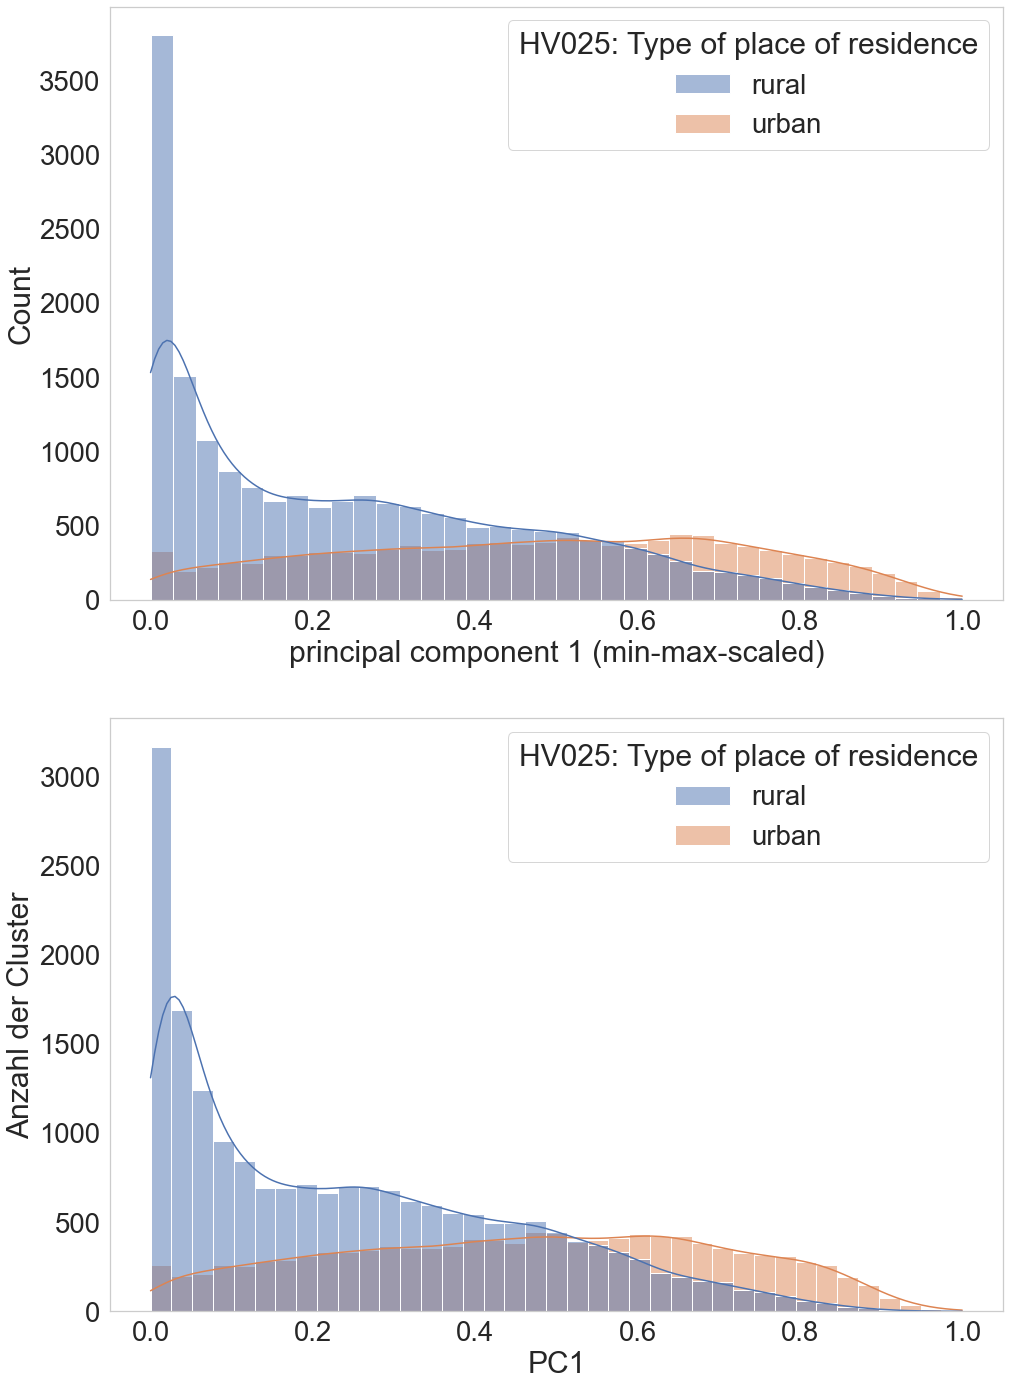

In [69]:
df, indikators, features = create_sub_samples(outlier_transformation="zscore", transformation=None, max_missing_per_row=0.3, indikators="female", min_oberservations=10, split_place=None)
cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
  
female_sets = [['MeanYearsOfSchooling_female',
 'AduldLiteracyRate_female',
 'AduldPrimaryGraduationRate_female',
 'AduldSecondaryGraduationRate_female'],    
['MeanYearsOfSchooling_female_imputed',
 'AduldLiteracyRate_female_imputed',
 'AduldPrimaryGraduationRate_female_imputed',
 'AduldSecondaryGraduationRate_female_imputed']]
    
data_aduld = run_pca(df=df, feature_set=female_sets[0], cols=cols)
data_aduld_imputed = run_pca(df=df, feature_set=female_sets[1], cols=cols)   
    
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(16, 24)

sns.set(font_scale=2.5, rc={'figure.figsize':(16,9)})
sns.set_style("whitegrid", {'axes.grid' : False})

sns.histplot(data=data_aduld, x="principal component 1 (min-max-scaled)", hue="HV025: Type of place of residence", kde=True, color="skyblue", ax = axes[0])
sns.histplot(data=data_aduld_imputed, x="principal component 1 (min-max-scaled)", hue="HV025: Type of place of residence", kde=True, color="skyblue", ax = axes[1])

plt.xlabel('PC1')
plt.ylabel('Anzahl der Cluster')
    
plt.show()

## Education Index
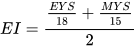

Skewness: -0.2705784415795112
Kurtosis: -0.6298471699633912


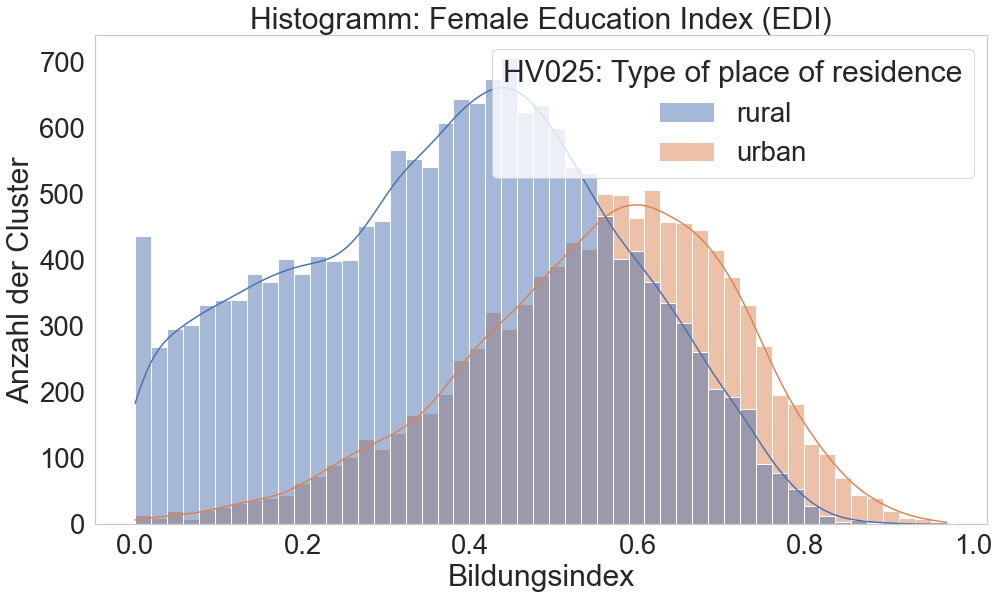

In [70]:
def ExpectedYearsOfSchooling(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]

    ### Remove cluster that didn't ask this questions
    EYS = SAMPLE_PUPILS
    EYS = EYS.dropna(subset='HV121: member attended school during current school year')

    ### Replace unnecessary attendance states by None and replace the relevant one with 1
    EYS['HV121: member attended school during current school year'] = EYS['HV121: member attended school during current school year'].replace([0,4], np.NaN).replace(2,1)

    ### Define the attendance rate for the existing age levels
    EYS = EYS[['HV121: member attended school during current school year', "ID", "HV105: age of household members"] + cols].groupby(cols+["HV105: age of household members"]).count().reset_index()
    EYS["ATTENDANCE_RATE_PER_AGE"] = EYS["HV121: member attended school during current school year"]/EYS["ID"]

    ### Group dictionaries
    EYS = EYS[cols + ["ATTENDANCE_RATE_PER_AGE", "HV105: age of household members"]].groupby(cols).agg(list).reset_index()
    EYS['AGE: ATTENDANCE_RATE'] = [ f(x) for x in EYS[['HV105: age of household members', 'ATTENDANCE_RATE_PER_AGE']].to_numpy()]

    ### Impute and keep entries that have values on all age levels
    EYS['AGE: ATTENDANCE_RATE - IMPUTED'] = EYS['AGE: ATTENDANCE_RATE'].apply(lambda x: impute(x))
    EYS['AGE: ATTENDANCE_RATE- LENGTH'] = EYS['AGE: ATTENDANCE_RATE - IMPUTED'].apply(len)
    EYS = EYS[EYS['AGE: ATTENDANCE_RATE- LENGTH']==19] 

    ###  and sum up the eys
    EYS['ExpectedYearsOfSchooling'] = EYS['AGE: ATTENDANCE_RATE - IMPUTED'].apply(lambda x: sum(x.values()))
    EYS = EYS[cols + ['ExpectedYearsOfSchooling']].sort_values(by='ExpectedYearsOfSchooling')
    
    return EYS.dropna()

EDI_EYS = ExpectedYearsOfSchooling('HV104: sex of household member')
EDI_EYS = EDI_EYS.pivot(index=["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="ExpectedYearsOfSchooling").reset_index().rename(columns={
                 "female": "ExpectedYearsOfSchooling_female",
                 "male": "ExpectedYearsOfSchooling_male"})

EDI_EYS["ExpectedYearsOfSchooling_female"] = EDI_EYS["ExpectedYearsOfSchooling_female"].apply(lambda x: 18.0 if x > 18.0 else x)
EDI_EYS = EDI_EYS.dropna(subset=['ExpectedYearsOfSchooling_female'])


def MeanYearsOfSchooling(disaggregation=None):
   
    cols = ["HV007: year of interview", 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', "HV000.0: country name"]
    if disaggregation != None:
        cols = cols + [disaggregation]
     
    df = SAMPLE_ADULTS.dropna(subset="HV108: education completed in single years").copy()
    df = pd.DataFrame(df[cols+["HV108: education completed in single years"]].groupby(cols).mean()).reset_index()
    df = df.rename(columns={"HV108: education completed in single years": "MeanYearsOfSchooling"})
    df = df.sort_values(by="MeanYearsOfSchooling")

    return df.dropna()

EDI_MYS = MeanYearsOfSchooling('HV104: sex of household member')
EDI_MYS = EDI_MYS.pivot(index=["HV007: year of interview", 'HV001: cluster number', 'HV025: Type of place of residence', 'HV000: country code', "HV000.0: country name"], 
          columns='HV104: sex of household member', 
          values="MeanYearsOfSchooling").reset_index().rename(columns={
                 "female": "MeanYearsOfSchooling_female",
                 "male": "MeanYearsOfSchooling_male"})

EDI_MYS['MeanYearsOfSchooling_female'] = EDI_MYS['MeanYearsOfSchooling_female'].apply(lambda x: 15.0 if x > 15.0 else x)
EDI_MYS = EDI_MYS.dropna(subset=['MeanYearsOfSchooling_female'])

# clculate Education index
cols = ["HV007: year of interview", 'HV000: country code','HV001: cluster number', 'HV025: Type of place of residence',  "HV000.0: country name"]
EDI = EDI_MYS.merge(EDI_EYS, on=cols)
EDI["EducationIndex_female"] = (((EDI["ExpectedYearsOfSchooling_female"]/18)+(EDI["MeanYearsOfSchooling_female"]/15))/2)
EDI["HV007: year of interview"] = EDI["HV007: year of interview"].astype(float).astype(int)

# merge with finalDf_female
final["HV007: year of interview"] = final["HV007: year of interview"].astype(float).astype(int)
final = EDI.merge(final, on=['HV007: year of interview', 'HV001: cluster number', 'HV025: Type of place of residence', 'HV000: country code', 'HV000.0: country name'], how="outer").drop_duplicates()
final = final.rename(columns={"principal component 1": "Female Education PCA",
    "principal component 1 (min-max-scaled)": "Female Education PCA (min-max-scaled)"})

# visualize
sns.set(rc={'figure.figsize':(16,9)})
sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid' : False})

ax = sns.histplot(data=EDI, x="EducationIndex_female", hue="HV025: Type of place of residence", kde=True, color="skyblue")

plt.title("Histogramm: Female Education Index (EDI)")
plt.xlabel('Bildungsindex')
plt.ylabel('Anzahl der Cluster')

print("Skewness:", EDI["EducationIndex_female"].skew())
print("Kurtosis:", EDI["EducationIndex_female"].kurtosis())

In [71]:
### map with UNESCO data
df_edi = pd.read_csv(projects_p + "/ressources/GDL-Educational-index--data.csv")
df_edi = df_edi[df_edi.columns[[0,5,24,25,26,27,28,29,30,31,32,33,34,35,36,37]]]
df_edi["Region"] = df_edi["Region"].apply(lambda x: re.sub(" \(.*?\)", '', x))
df_edi = df_edi.melt(id_vars=["Country", "Region"], 
        var_name="HV007: year of interview", 
        value_name="EDI").rename(columns={"Country": "adm0_name", "Region": "adm1_name"})

df_edi["adm1_name"] = df_edi["adm1_name"].apply(lambda x: str(x).split("/")[0])
df_edi["HV007: year of interview"] = df_edi["HV007: year of interview"].astype(float).astype(int)

final["adm0_name"] = final["adm0_name"].replace(["Côte d'Ivoire", "United Republic of Tanzania"], ["Cote d'Ivoire", "Tanzania"])
final = final.merge(df_edi, on=['adm0_name', 'adm1_name', 'HV007: year of interview'], how="left")
final.rename(columns={"EDI": "EDI (UNESCO)", "EducationIndex_female": "EDI"}, inplace=True)

# rescale 
final["EDI (UNESCO) (min-max-scaled)"] = scaler.fit_transform(final[["EDI (UNESCO)"]])
final["EDI (min-max-scaled)"] = scaler.fit_transform(final[["EDI"]])

# drop observations without mapping satellite data
final = final[['DHSID', 'HV007: year of interview', "HV000: country code", 'Female Education PCA', "Female Education PCA (min-max-scaled)", 'EDI', "EDI (min-max-scaled)","EDI (UNESCO)", "EDI (UNESCO) (min-max-scaled)", "Imputed", "Observations", 'DHSYEAR', 'URBAN_RURA', 'LATNUM', 'LONGNUM', 'GEID', 'adm2_name', 'adm1_name', 'adm0_name']]

coefficient of determination: 0.8961138214386367
intercept: -0.024468350886032053
slope: [1.01394472]


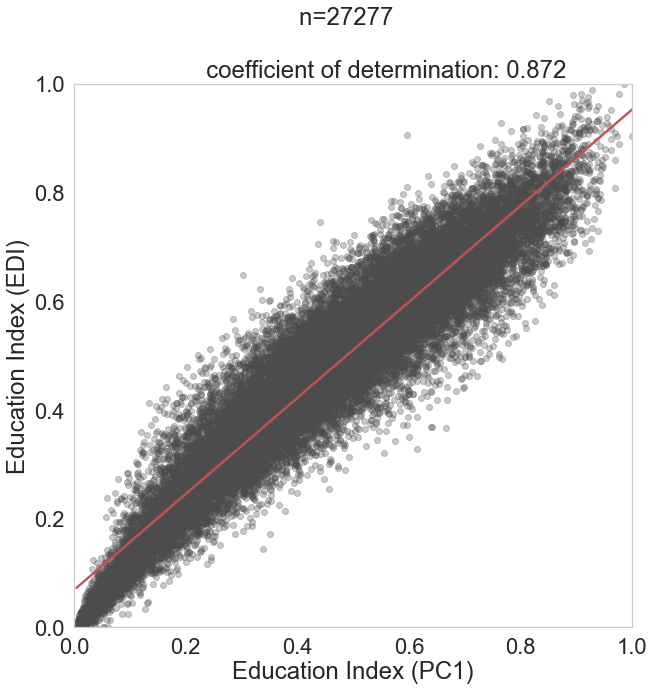

In [114]:
#linear regression line
import numpy as np
from sklearn.linear_model import LinearRegression

finalDf_female_cluster = final.dropna(subset=["Female Education PCA (min-max-scaled)", "EDI (min-max-scaled)"])

sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=2)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.regplot(data=finalDf_female_cluster, x="Female Education PCA (min-max-scaled)", y="EDI (min-max-scaled)", 
                scatter_kws={'alpha':0.3}, color=".3", line_kws=dict(color="r")).set(ylim=(0, 1), xlim=(0, 1))

#plt.title("Lineare Regression: \n Education Index (PC1) vs. \n Education Index (EDI) je Cluster und Erhebungsjahr")
plt.title(f"""n={len(finalDf_female_cluster.index)}  \n
          coefficient of determination: {round(r_sq, 3)}""")
        
plt.xlabel('Education Index (PC1)')
plt.ylabel('Education Index (EDI)')

y=np.array(finalDf_female_cluster["Female Education PCA (min-max-scaled)"])
x=np.array(finalDf_female_cluster["EDI (min-max-scaled)"]).reshape((-1, 1))

model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)

print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")
#https://realpython.com/linear-regression-in-python/

coefficient of determination: 0.8715672548233424
intercept: 0.030542808062125004
slope: [1.1333772]


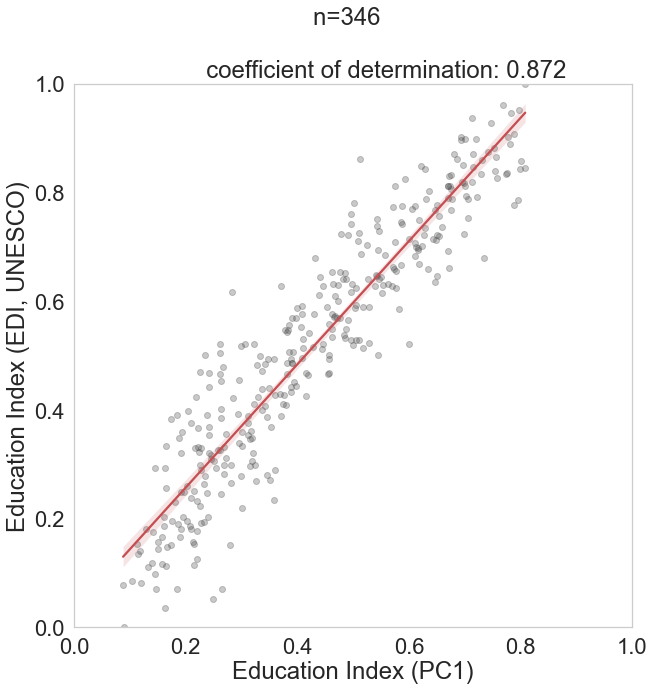

In [113]:
#linear regression line
import numpy as np
from sklearn.linear_model import LinearRegression

finalDf_female_region = final.groupby(["adm0_name","adm1_name", 'HV007: year of interview']).mean().reset_index().dropna(subset=["Female Education PCA (min-max-scaled)", "EDI (UNESCO) (min-max-scaled)"])

sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=2)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.regplot(data=finalDf_female_region, x="Female Education PCA (min-max-scaled)", y="EDI (UNESCO) (min-max-scaled)", 
                scatter_kws={'alpha':0.3}, color=".3", line_kws=dict(color="r")).set(ylim=(0, 1), xlim=(0, 1))

#plt.title("b) Lineare Regression: \n Female Education Index (PC1) vs. \n Female Education Index (EDI, UNESCO) je Distrikt und Erhebungsjahr")
plt.title(f"""n={len(finalDf_female_region.index)}  \n
          coefficient of determination: {round(r_sq, 3)}""")
        
plt.xlabel('Education Index (PC1)')
plt.ylabel('Education Index (EDI, UNESCO)')

x=np.array(finalDf_female_region["Female Education PCA (min-max-scaled)"]).reshape((-1, 1))
y=np.array(finalDf_female_region["EDI (UNESCO) (min-max-scaled)"])

model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)

# Vorhersagen
y_pred = model.predict(x)

# Residuen berechnen
residuals = y - y_pred

# Schwelle für Ausreißer festlegen (zum Beispiel zwei Standardabweichungen)
threshold = 2 * np.std(residuals)

# Punkte mit großen Residuen als Ausreißer markieren
outliers_mask = np.abs(residuals) > threshold

print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")
#https://realpython.com/linear-regression-in-python/

coefficient of determination: 0.8746357579084234
intercept: -0.04442764232064622
slope: [1.26240337]
coefficient of determination: 0.8746357579084234
intercept: -0.04442764232064622
slope: [1.26240337]


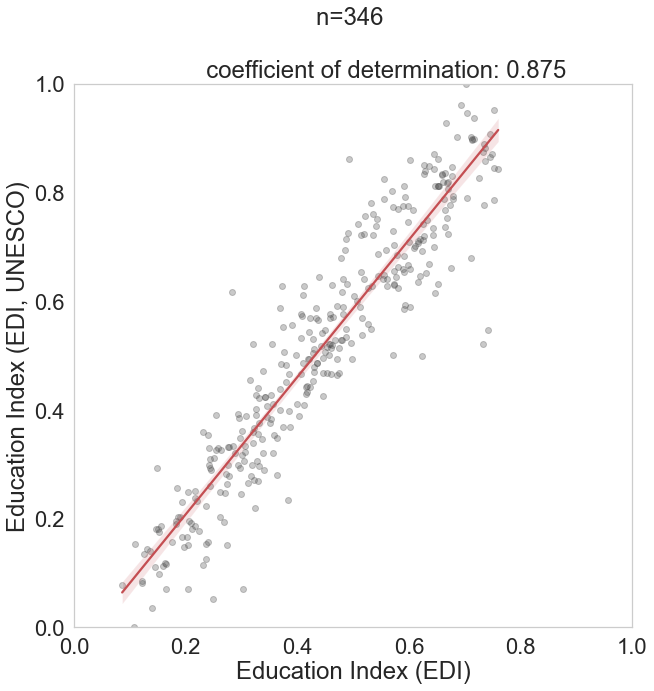

In [110]:
#linear regression line
import numpy as np
from sklearn.linear_model import LinearRegression

finalDf_female_region = final.groupby(["adm0_name","adm1_name", 'HV007: year of interview']).mean().reset_index().dropna(subset=["EDI (min-max-scaled)", "EDI (UNESCO) (min-max-scaled)"])

sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=2)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.regplot(data=finalDf_female_region, x="EDI (min-max-scaled)", y="EDI (UNESCO) (min-max-scaled)", 
                scatter_kws={'alpha':0.3}, color=".3", line_kws=dict(color="r")).set(ylim=(0, 1), xlim=(0, 1))

#plt.title("b) Lineare Regression: \n Female Education Index (EDI) vs. \n Female Education Index (EDI, UNESCO) je Distrikt und Erhebungsjahr")
plt.title(f"""n={len(finalDf_female_region.index)} \n
          coefficient of determination: {round(r_sq, 3)}""")


print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")


plt.xlabel('Education Index (EDI)')
plt.ylabel('Education Index (EDI, UNESCO)')

x=np.array(finalDf_female_region["EDI (min-max-scaled)"]).reshape((-1, 1))
y=np.array(finalDf_female_region["EDI (UNESCO) (min-max-scaled)"])

model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)

# Vorhersagen
y_pred = model.predict(x)

# Residuen berechnen
residuals = y - y_pred

# Schwelle für Ausreißer festlegen (zum Beispiel zwei Standardabweichungen)
threshold = 2 * np.std(residuals)

# Punkte mit großen Residuen als Ausreißer markieren
outliers_mask = np.abs(residuals) > threshold

print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")
#https://realpython.com/linear-regression-in-python/

In [88]:
finalDf_female_region["HV007: year of interview"].unique()

array([2012, 2017, 2010, 2021, 2011, 2018, 2014, 2019, 2013, 2015, 2016],
      dtype=int64)

In [76]:
finalDf_female_region#["adm0_name"].unique()

adm0_name            adm1_name  HV007: year of interview  Female Education PCA  Female Education PCA (min-max-scaled)       EDI  EDI (min-max-scaled)  EDI (UNESCO)  EDI (UNESCO) (min-max-scaled)  Observations  DHSYEAR     LATNUM    LONGNUM
24          Benin               Borgou                      2012             -1.922672                               0.281206  0.308687              0.318599         0.287                       0.299419    135.163934   2012.0   9.726146   2.785930
25          Benin               Borgou                      2017             -3.298887                               0.162512  0.143375              0.147978         0.283                       0.293605    175.068966   2017.0   9.998187   2.816126
35          Benin                 Mono                      2012             -0.716306                               0.385250  0.377464              0.389584         0.463                       0.555233    102.775510   2012.0   6.546895   1.814415
36          Benin                 Mono                      2017             -0.887463                               0.370489  0.361593              0.373204         0.513                       0.627907     92.000000   2017.0   6.502079   1.890706
42          Benin                  Zou                      2012             -1.644205                               0.305223  0.309631              0.319573         0.439                       0.520349    105.777778   2012.0   7.192270   2.124648
43          Benin                  Zou                      2017             -1.899190                               0.283231  0.273411              0.282190         0.506                       0.617733    113.625000   2017.0   7.217158   2.157071
47   Burkina Faso             Cascades                      2010             -2.573097                               0.225109  0.228559              0.235898         0.234                       0.222384    142.941176   2010.0  10.482716  -4.741084
48   Burkina Faso             Cascades                      2021             -1.171363                               0.346003  0.333925              0.344648         0.347                       0.386628    159.142857   2021.0  10.584254  -4.828952
49   Burkina Faso               Centre                      2010             -0.680529                               0.388336  0.406406              0.419456         0.420                       0.492733    135.040816   2010.0  12.351765  -1.534828
50   Burkina Faso               Centre                      2021              0.757575                               0.512367  0.476967              0.492283         0.674                       0.861919    122.955882   2021.0  12.352524  -1.524706
59   Burkina Faso                  Est                      2010             -3.473491                               0.147454  0.160246              0.165392         0.129                       0.069767    152.772727   2010.0  12.346823   0.569705
60   Burkina Faso                  Est                      2021             -1.938924                               0.279804  0.265683              0.274214         0.185                       0.151163    171.703704   2021.0  12.480774   0.093037
63   Burkina Faso                 Nord                      2010             -2.785742                               0.206769  0.210102              0.216848         0.209                       0.186047    142.659091   2010.0  13.363014  -2.250186
64   Burkina Faso                 Nord                      2021             -1.474451                               0.319863  0.326979              0.337479         0.301                       0.319767    181.564103   2021.0  13.237167  -2.204744
65   Burkina Faso      Plateau Central                      2010             -2.638678                               0.219453  0.217453              0.224435         0.203                       0.177326    153.000000   2010.0  12.406961  -1.129634
66   Burkina Faso      Plateau Central  

### Export - Eingrenzen auf den Zeitraum 2015-2020

In [115]:
projects_p

'/Users/julii/PycharmProjects/Education/pca'

In [77]:
missing_urban = pd.read_csv(r"..\inputs\sentinel2\U\missing_files.csv")
missing_rural = pd.read_csv(r"..\inputs\sentinel2\R\missing_files.csv")

missing = pd.concat([missing_urban, missing_rural])[["DHSYEAR", "LATNUM", "LONGNUM"]]

export = final[(final["HV007: year of interview"]>2014)&(final["HV007: year of interview"]<2021)]
cols = ['DHSID', 'Female Education PCA', 'Female Education PCA (min-max-scaled)', 'EDI', 'EDI (min-max-scaled)', 'EDI (UNESCO)', 'EDI (UNESCO) (min-max-scaled)', 'Imputed', 'Observations', 'DHSYEAR', 'URBAN_RURA', 'LATNUM', 'LONGNUM', 'GEID', 'adm2_name', 'adm1_name', 'adm0_name']

export.dropna(subset=['LATNUM', 'LONGNUM', 'adm2_name','adm1_name', 'adm0_name'], inplace=True)
export = export.rename(columns={"Observations":"households",'EducationIndex_female': 'EDI','EDI (UNESCO)': 'EDI (UNESCO)'})
export["ISO3"] = export["adm0_name"].apply(lambda x: cc.convert(names=[x], to='ISO3'))
export["TIF_name"] = export['GEID'] + export['DHSID'].apply(lambda x: x[6:]) + ".tif"

drop_cluster = export.merge(missing, on=["DHSYEAR", "LATNUM", "LONGNUM"], how="inner")["DHSID"]
export = export[export["DHSID"].isin(drop_cluster)==False]
export = export.merge(DHS[DHS["HV104: sex of household member"]=="female"][['HV105: age of household members', "DHSID"]].groupby(["DHSID"]).mean().reset_index().rename(columns={"HV105: age of household members": "MEAN_AGE"}).merge(DHS[DHS["HV104: sex of household member"]=="female"][['HV105: age of household members', "DHSID"]].groupby(["DHSID"]).std().reset_index().rename(columns={"HV105: age of household members": "STD_AGE"})),
            on="DHSID", how="left")

In [78]:
#all
df_all = export#[export['adm0_name']!="Rwanda"]
df_all.to_csv("../inputs/label/Education_Labels.csv", index=False)

#urban
df_urban = export[export["URBAN_RURA"]=="U"]  #(export['adm0_name']!="Rwanda")&
df_urban.to_csv("../inputs/label/Education_Labels_Urban.csv", index=False)

#rural
df_rural = export[export["URBAN_RURA"]=="R"]
df_rural.to_csv("../inputs/label/Education_Labels_Rural.csv", index=False)

#nigeria
df_rwanda = export[export['adm0_name']=="Rwanda"]
df_rwanda.to_csv("../inputs/label/Education_Labels_Rwanda.csv", index=False)

print("Female Education PCA: ", len(df_all.dropna(subset='Female Education PCA')))
print("Female Education PCA (Countries): ", len(df_all.dropna(subset='Female Education PCA').groupby("adm0_name").count()))
print("Urban - Female Education PCA: ", len(df_urban.dropna(subset='Female Education PCA')))
print("Urban (Countries) - Female Education PCA: ", len(df_urban.dropna(subset='Female Education PCA').groupby("adm0_name").count()))
print("Rural - Female Education PCA: ", len(df_rural.dropna(subset='Female Education PCA')))
print("Rural (Countries) - Female Education PCA: ", len(df_rural.dropna(subset='Female Education PCA').groupby("adm0_name").count()))

data_child = data_child[['principal component 1', 'HV007: year of interview', 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', 'HV000.0: country name', 'principal component 1 (min-max-scaled)']]
data_youth = data_youth[['principal component 1', 'HV007: year of interview', 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', 'HV000.0: country name', 'principal component 1 (min-max-scaled)']]
data_aduld = data_aduld[['principal component 1', 'HV007: year of interview', 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', 'HV000.0: country name', 'principal component 1 (min-max-scaled)']]

data_merged = data_child.merge(data_aduld, suffixes=('_child', '_aduld'), on=['HV007: year of interview', 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', 'HV000.0: country name'])
data_merged = data_merged.merge(data_youth, on=['HV007: year of interview', 'HV000: country code', 'HV001: cluster number', 'HV025: Type of place of residence', 'HV000.0: country name'])
data_merged = data_merged.rename(columns={"principal component 1": "principal component 1_youth", "principal component 1 (min-max-scaled)": "principal component 1 (min-max-scaled)_youth"})
data_merged.insert(0, 'DHSID', data_merged["HV000: country code"]+data_merged["HV007: year of interview"].apply(lambda x: str(x)[:4])+data_merged["HV001: cluster number"].apply(lambda x: str(int(x)).rjust(8, "0")))        
data_merged = df_all[['DHSYEAR', 'DHSID', 'URBAN_RURA', 'LATNUM', 'LONGNUM', 'GEID', 'adm2_name', 'adm1_name', 'adm0_name']].merge(data_merged, on=["DHSID"])
data_merged.to_csv(r"../inputs/label/Education_Labels_Child_Youth_Aduld.csv", index=False)

Female Education PCA:  8046
Female Education PCA (Countries):  17
Urban - Female Education PCA:  3041
Urban (Countries) - Female Education PCA:  17
Rural - Female Education PCA:  5005
Rural (Countries) - Female Education PCA:  16


In [79]:
df_all["adm0_name"].unique()

array(['Mozambique', 'Tanzania', 'Zimbabwe', 'Senegal', 'Malawi',
       'Angola', 'Uganda', 'Benin', 'Mali', 'Zambia', 'Cameroon',
       'Guinea', 'Nigeria', 'Liberia', 'Gambia', 'Sierra Leone', 'Rwanda'],
      dtype=object)

In [80]:
export_rural = df_rural
export_urban = df_urban

fig2, axes2 = plt.subplots(3, 1)
fig2.set_size_inches(16*5, 9*3*5)
fig2.tight_layout(pad=3.0)

sns.set(font_scale=10, rc={'figure.figsize':(16*5, 9*3*5)})
sns.set_style("whitegrid", {'axes.grid' : False})

sns.histplot(stat="count", multiple="stack", bins=50, hue_order=["False", "True"], hue=export['Imputed'], data=export, x=export["Female Education PCA (min-max-scaled)"].rename("Index"), kde=False, palette=['grey', 'black'], ax = axes2[0]).set(title=f"Histogramm: PC1-Index \n n={len(export.index)}", ylabel='Anzahl', ylim=(0, 300), xlim=(0, 1))
sns.histplot(stat="count", multiple="stack",bins=50, hue_order=["False", "True"], hue=export_rural['Imputed'], data=export_rural, x=export_rural["Female Education PCA (min-max-scaled)"].rename("Index"), kde=False, palette=[sns.color_palette()[1], 'black'], ax = axes2[1]).set(title=f"Histogramm: PC1-Index (Rural) \n n={len(export_rural.index)}", ylabel='Anzahl', ylim=(0, 200), xlim=(0, 1))
sns.histplot(stat="count", multiple="stack",bins=50, hue_order=["False", "True"], hue=export_urban['Imputed'], data=export_urban, x=export_urban["Female Education PCA (min-max-scaled)"].rename("Index"), kde=False, palette=[sns.color_palette()[0], 'black'], ax = axes2[2]).set(title=f"Histogramm: PC1-Index (Urban) \n n={len(export_urban.index)}", ylabel='Anzahl', ylim=(0, 150), xlim=(0, 1))

plt.show()

plt.savefig(projects_p + r"\Education\Grafiken\Histogramms_2015_2019.png")

<Figure size 5760x9720 with 0 Axes>

In [81]:
from scipy.stats import describe

print(describe(export["Female Education PCA (min-max-scaled)"], axis=0), '\n')
print(shapiro(export["Female Education PCA (min-max-scaled)"].values))

DescribeResult(nobs=8046, minmax=(0.003979302631006876, 0.9684558434752211), mean=0.427248406718037, variance=0.049292917706088256, skewness=0.04158287310962434, kurtosis=-0.8189706238581191) 

ShapiroResult(statistic=0.9836310148239136, pvalue=1.8583448496669344e-29)


In [82]:
print(describe(export_rural["Female Education PCA (min-max-scaled)"], axis=0), '\n')
print(shapiro(export_rural["Female Education PCA (min-max-scaled)"].values))
print(export_rural["Female Education PCA (min-max-scaled)"].median())

DescribeResult(nobs=5005, minmax=(0.003979302631006876, 0.9370389876615488), mean=0.3423750755471433, variance=0.03954781006539288, skewness=0.32575867381540813, kurtosis=-0.5317092039203688) 

ShapiroResult(statistic=0.9798842668533325, pvalue=4.621850070177191e-26)
0.3300140520425944


In [83]:
print(describe(export_urban["Female Education PCA (min-max-scaled)"], axis=0), '\n')
print(shapiro(export_urban["Female Education PCA (min-max-scaled)"].values))
print(export_urban["Female Education PCA (min-max-scaled)"].median())

DescribeResult(nobs=3041, minmax=(0.003979302631006876, 0.9684558434752211), mean=0.5669363457217603, variance=0.03397127296202685, skewness=-0.38232470872006613, kurtosis=-0.24258680898862517) 

ShapiroResult(statistic=0.9860549569129944, pvalue=9.801377559937602e-17)
0.5794792207906123


In [84]:
export[['adm0_name', 'HV007: year of interview', "Female Education PCA (min-max-scaled)", 'EDI (min-max-scaled)']].groupby(['HV007: year of interview', "adm0_name"]).mean().reset_index()

HV007: year of interview     adm0_name  Female Education PCA (min-max-scaled)  EDI (min-max-scaled)
0                       2015        Angola                               0.366552              0.463627
1                       2015        Malawi                               0.424874              0.508450
2                       2015    Mozambique                               0.377714              0.412786
3                       2015       Senegal                               0.306022              0.323334
4                       2015      Tanzania                               0.537046              0.476626
5                       2015      Zimbabwe                               0.635625              0.643506
6                       2016        Uganda                               0.400344              0.491092
7                       2017         Benin                               0.288506              0.293540
8                       2017       Senegal                               0.327982              0.350901
9                       2018      Cameroon                               0.540811              0.555655
10                      2018        Guinea                               0.251542              0.282977
11                      2018          Mali                               0.235838              0.246064
12                      2018       Nigeria                               0.534015              0.506863
13                      2018       Senegal                               0.321076              0.342686
14                      2018        Zambia                               0.478722              0.516378
15                      2019        Gambia                               0.608825              0.578724
16                      2019       Liberia                               0.310391              0.455255
17                      2019        Rwanda                               0.515335              0.476980
18                      2019       Senegal                               0.327263              0.349688
19                      2019  Sierra Leone                               0.385382              0.451654